Initial import of the dataset and viewing of the data

In [60]:
import pandas as pd
import os
import matplotlib.pyplot as plt
data = pd.read_csv("recorded_crime_ireland.csv")
data.head

<bound method NDFrame.head of                                   STATISTIC Label Quarter   
0       Recorded Crime Offences under Reservation  2003Q1  \
1       Recorded Crime Offences under Reservation  2003Q1   
2       Recorded Crime Offences under Reservation  2003Q1   
3       Recorded Crime Offences under Reservation  2003Q1   
4       Recorded Crime Offences under Reservation  2003Q1   
...                                           ...     ...   
157047  Recorded Crime Offences under Reservation  2022Q3   
157048  Recorded Crime Offences under Reservation  2022Q3   
157049  Recorded Crime Offences under Reservation  2022Q3   
157050  Recorded Crime Offences under Reservation  2022Q3   
157051  Recorded Crime Offences under Reservation  2022Q3   

                       Garda Division   
0       Cavan/Monaghan Garda Division  \
1       Cavan/Monaghan Garda Division   
2       Cavan/Monaghan Garda Division   
3       Cavan/Monaghan Garda Division   
4       Cavan/Monaghan Garda Div

In [61]:
data['Garda Division'].unique()

array(['Cavan/Monaghan Garda Division', 'Donegal Garda Division',
       'Sligo/Leitrim Garda Division', 'Louth Garda Division',
       'Clare Garda Division', 'Mayo Garda Division',
       'Galway Garda Division', 'Roscommon/Longford Garda Division',
       'Cork City Garda Division', 'Cork North Garda Division',
       'Cork West Garda Division', 'Kerry Garda Division',
       'Limerick Garda Division', 'Laois/Offaly Garda Division',
       'Meath Garda Division', 'Wicklow Garda Division',
       'Westmeath Garda Division', 'Kildare Garda Division',
       'Tipperary Garda Division', 'Wexford Garda Division',
       'Kilkenny/Carlow Garda Division', 'Waterford Garda Division',
       'D.M.R. South Central Garda Division',
       'D.M.R. North Central Garda Division',
       'D.M.R. Northern Garda Division', 'D.M.R. Southern Garda Division',
       'D.M.R. Eastern Garda Division', 'D.M.R. Western Garda Division'],
      dtype=object)

Basic View of what we are working with

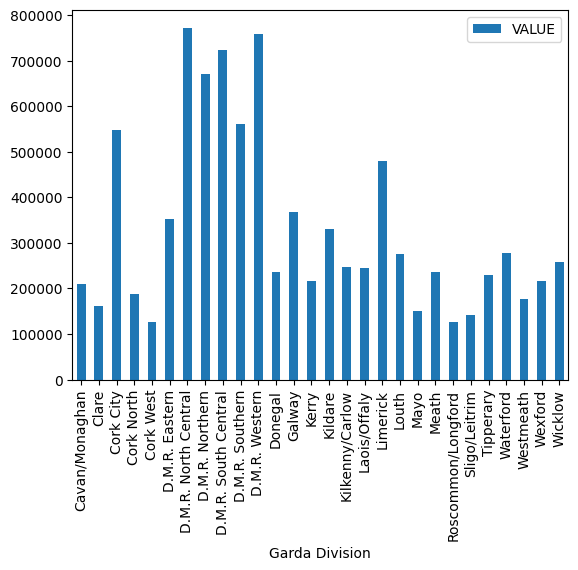

In [62]:
group_data = data.groupby('Garda Division').sum()
group_data.index = group_data.index.str.replace(' Garda Division', '')
group_data.plot(kind='bar', y='VALUE')
plt.xlabel('Garda Division')
plt.show()

We can try to fit a linear regression model to see which way crime rates are trending. We filter out covid years to remove the effects

In [63]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Filter out 2020 data
data = data[data['Quarter'] != '2020Q1']
data = data[data['Quarter'] != '2020Q2']
data = data[data['Quarter'] != '2020Q3']
data = data[data['Quarter'] != '2020Q4']
group_data = data.groupby('Quarter').sum()
x_data = group_data.index.str.replace('Q', '.').astype(float).values.reshape(-1, 1)
y_data = group_data['VALUE'].values.reshape(-1, 1)
model = LinearRegression().fit(x_data, y_data)


print('Slope: ', model.coef_[0])
print('Intercept: ', model.intercept_)

Slope:  [-1911.00286471]
Intercept:  [3964139.5590923]


Linear regression is subject to an external factor possibly seasonal changes in crime rates - let's fix this

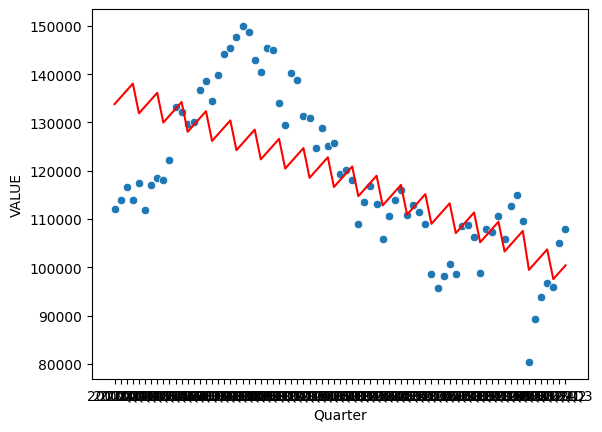

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

group_data = data.groupby('Quarter').sum()
group_data = group_data[group_data.index != '2020Q1']
group_data = group_data[group_data.index != '2020Q2']
group_data = group_data[group_data.index != '2020Q3']
group_data = group_data[group_data.index != '2020Q4']

sns.scatterplot(x=group_data.index, y='VALUE', data=group_data)

X = [[int(q[:4]), int(q[5:])] for q in group_data.index]
y = group_data['VALUE']
model = LinearRegression().fit(X, y)

x_pred = [[year, quarter] for year in range(2003, 2023) for quarter in range(1, 5)]
y_pred = model.predict(x_pred)

plt.plot([q for q in group_data.index], model.predict(X), color='red')
plt.show()


We reduce the examination period from quarters to years to remove the external factor at play (most likely seasonal fluctuations)

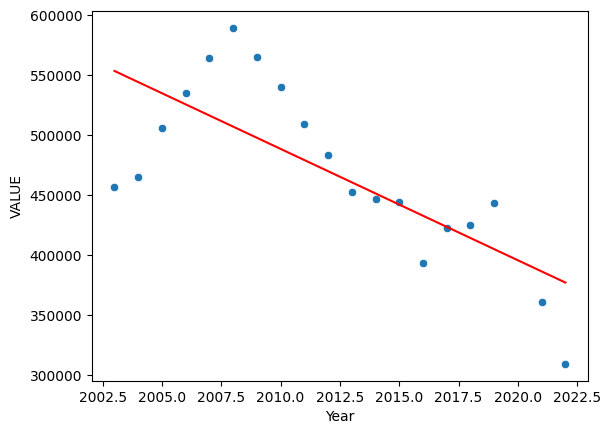

In [65]:
data['Year'] = data['Quarter'].apply(lambda x: int(x[:4]))

group_data = data.groupby('Year').sum()
group_data = group_data[group_data.index != 2020]

sns.scatterplot(x=group_data.index, y='VALUE', data=group_data)

X = [[year] for year in group_data.index]
y = group_data['VALUE']
model = LinearRegression().fit(X, y)

x_pred = [[year] for year in range(2003, 2023)]
y_pred = model.predict(x_pred)

plt.plot(x_pred, y_pred, color='red')
plt.show()

Let's visualise this data on a map using folium. We have to map the values in our dataset to the values in the geojson file and black spots occur in the map (no data) in cases where there is data for Roscommon/Longford Garda Division and we assign it to the bigger county

In [66]:
locations_dict = {
    'Fingal': 'D.M.R. North Central Garda Division',
    'Waterford City': 'Waterford Garda Division',
    'Kerry County': 'Kerry Garda Division',
    'Roscommon County': 'Roscommon/Longford Garda Division',
    'South Dublin': 'D.M.R. Eastern Garda Division',
    'Monaghan County': 'Cavan/Monaghan Garda Division',
    'Laois County': 'Laois/Offaly Garda Division',
    'Wexford County': 'Wexford Garda Division',
    'Limerick City': 'Limerick Garda Division',
    'Westmeath County': 'Westmeath Garda Division',
    'Dublin City': 'D.M.R. Southern Garda Division',
    'Clare County': 'Clare Garda Division',
    'Waterford County': 'Waterford Garda Division',
    'Limerick County': 'Limerick Garda Division',
    'South Tipperary': 'Tipperary Garda Division',
    'Galway City': 'Galway Garda Division',
    'Louth County': 'Louth Garda Division',
    'Kilkenny County': 'Kilkenny/Carlow Garda Division',
    'North Tipperary': 'Tipperary Garda Division',
    'Galway County': 'Galway Garda Division',
    'Kildare County': 'Kildare Garda Division',
    'Cavan County': 'Cavan/Monaghan Garda Division',
    'Leitrim County': 'Sligo/Leitrim Garda Division',
    'Sligo County': 'Sligo/Leitrim Garda Division',
    'Meath County': 'Meath Garda Division',
    'Offaly County': 'Laois/Offaly Garda Division',
    'Wicklow County': 'Wicklow Garda Division',
    'Longford County': 'Roscommon/Longford Garda Division',
    'DÃºn Laoghaire-Rathdown': 'D.M.R. Eastern Garda Division',
    'Donegal County': 'Donegal Garda Division',
    'Mayo County': 'Mayo Garda Division',
    'Carlow County': 'Kilkenny/Carlow Garda Division',
    'Cork City': 'Cork City Garda Division',
    'Cork County': 'Cork North Garda Division'
}


Putting a chloropleth on the data to visualise this using our dictionary created above

In [67]:
import pandas as pd
import folium
import json

data = pd.read_csv('recorded_crime_ireland.csv')
data['Garda Division'] = data['Garda Division'].replace(locations_dict)
area_data = data.groupby('Garda Division')['VALUE'].sum().reset_index()

map = folium.Map(location=[53.5, -8], zoom_start=7)
geojson_data = json.load(open('map.geojson'))

folium.Choropleth(
    geo_data=geojson_data,
    name='choropleth',
    data=area_data,
    columns=['Garda Division', 'VALUE'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Crime count'
).add_to(map)

folium.LayerControl().add_to(map)
map.save('crime_map.html')


We use a crime dict to group together similar crimes to try and identify insights within the data

In [68]:
crime_dict = {
    'Homicide': ['Homicide offences', 'Murder', 'Manslaughter', 'Infanticide'],
    'Dangerous Driving': ['Dangerous driving leading to death', 'Dangerous driving causing serious bodily harm', 'Driving/in charge of a vehicle while over legal alcohol limit', 'Driving/in charge of a vehicle under the influence of drugs'],
    'Sexual Offences': ['Sexual offences', 'Rape and sexual assault', 'Other sexual offences'],
    'Assault': ['Attempts/threats to murder, assaults, harassments and related offences', 'Murder-attempt', 'Threat to kill or cause serious harm', 'Harassment and related offences', 'Assault causing harm, poisoning', 'Other assault'],
    'Endangerment': ['Endangerment with potential for serious harm/death', 'Unseaworthy/dangerous use of boat or ship', 'Endangering traffic offences'],
    'Child Neglect and Cruelty': ['Abandoning a child, child neglect and cruelty'],
    'Kidnapping': ['Kidnapping and related offences', 'False imprisonment', 'Abduction of person under 16 years of age', 'Human trafficking offences'],
    'Robbery and Extortion': ['Robbery, extortion and hijacking offences', 'Robbery of an establishment or institution', 'Robbery of cash or goods in transit', 'Robbery from the person', 'Blackmail or extortion', 'Carjacking, hijacking/unlawful seizure of aircraft/vessel'],
    'Burglary': ['Burglary and related offences', 'Aggravated burglary', 'Burglary (not aggravated)', 'Possession of an article (with intent to burgle, steal, demand)'],
    'Theft and Handling Stolen Property': ['Theft and related offences', 'Theft/taking of vehicle and related offences', 'Theft from person', 'Theft from shop', 'Other thefts, handling stolen property'],
    'Fraud and Deception': ['Fraud, deception and related offences'],
    'Drug Offences': ['Controlled drug offences', 'Importation of drugs', 'Cultivation or manufacture of drugs', 'Possession of drugs for sale or supply', 'Possession of drugs for personal use', 'Other drug offences'],
    'Weapons and Explosives Offences': ['Weapons and Explosives Offences', 'Explosives, chemical weapons offences', 'Discharging a firearm', 'Possession of a firearm', 'Offensive weapons offences (n.e.c.)', 'Fireworks offences'],
    'Damage to Property and to the Environment': ['Damage to property and to the environment', 'Arson', 'Criminal damage (not arson)', 'Litter offences'],
    'Public Order and Social Code Offences': ['Public order and other social code offences', 'Disorderly conduct', 'Trespass offences', 'Liquor licensing offences', 'Prostitution offences', 'Regulated betting/money, collection/trading offences', 'Social code offences (n.e.c.)'],
    'Offences against Government and Justice Procedures': ['Offences against government, justice procedures and organisation of crime', 'Offences against government and its agents', 'Organisation of crime and conspiracy to commit crime', 'Perverting the course of justice', 'Offences while in custody, breach of court orders']
}

Grouping each of the above grouped crime activities by quarter iteratively to identify high-level trends in the data

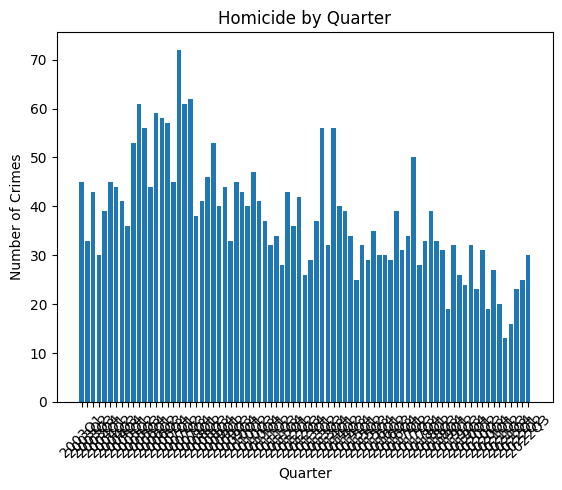

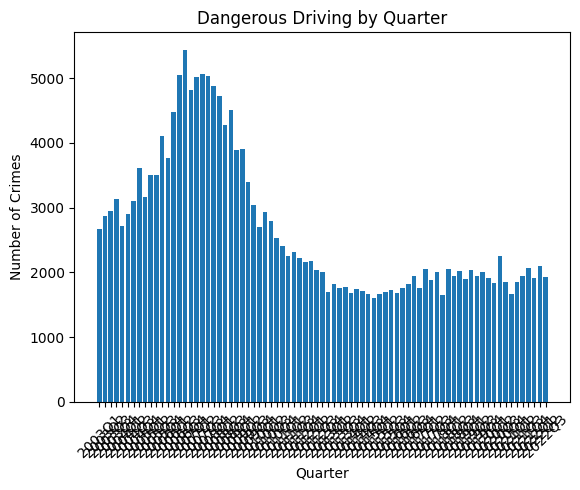

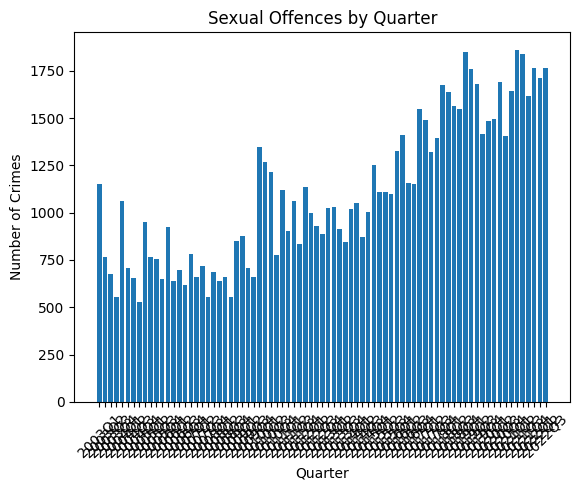

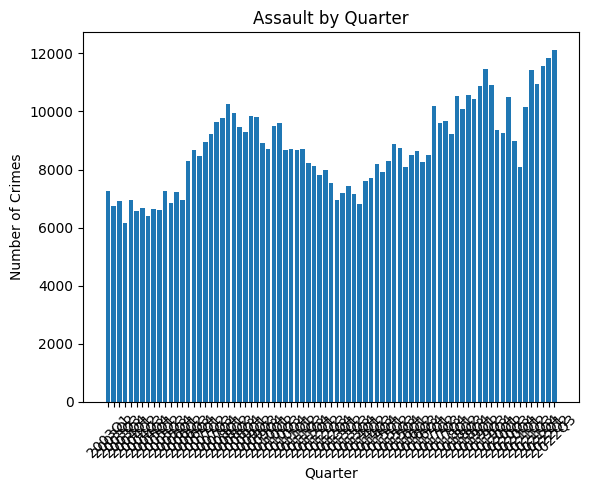

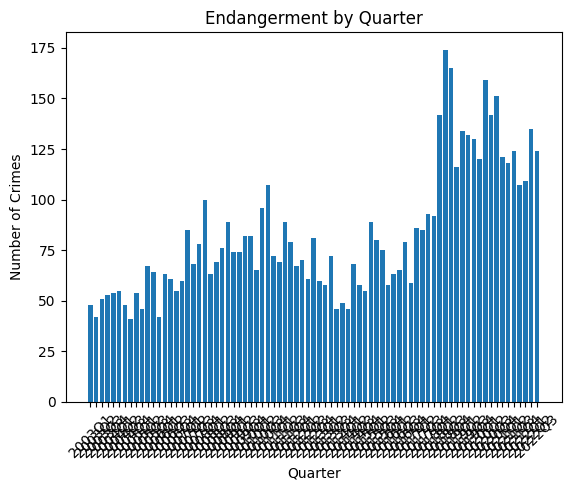

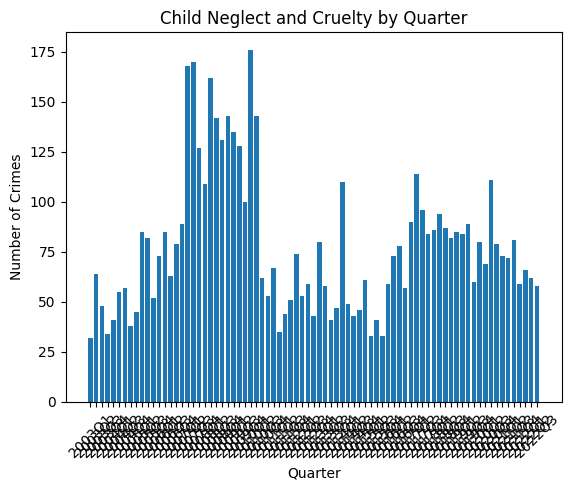

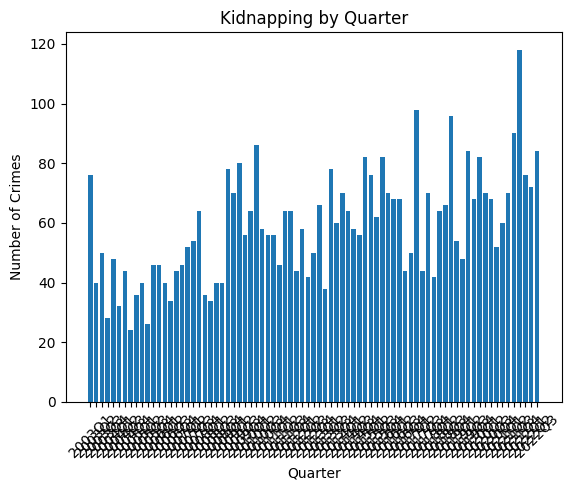

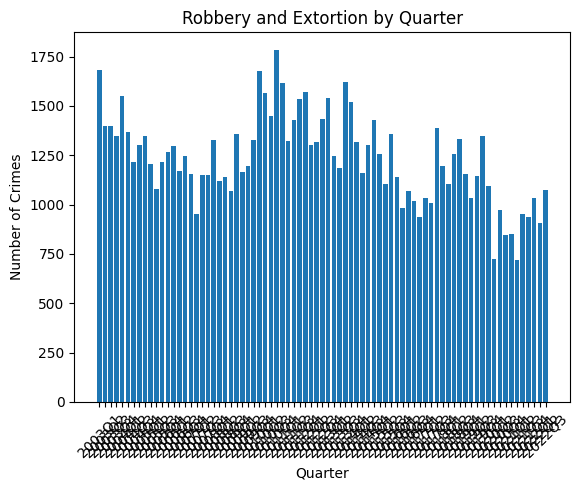

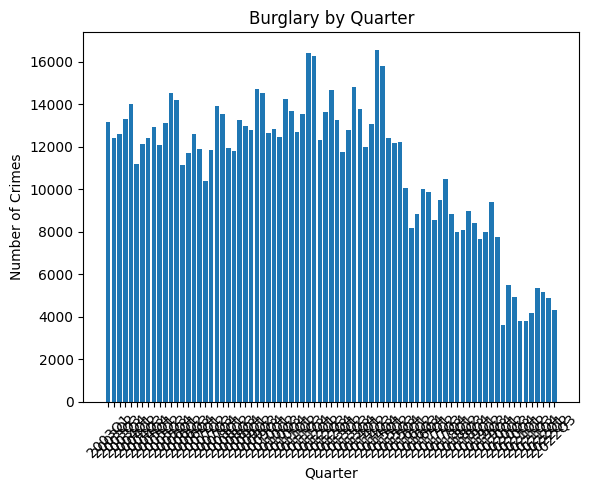

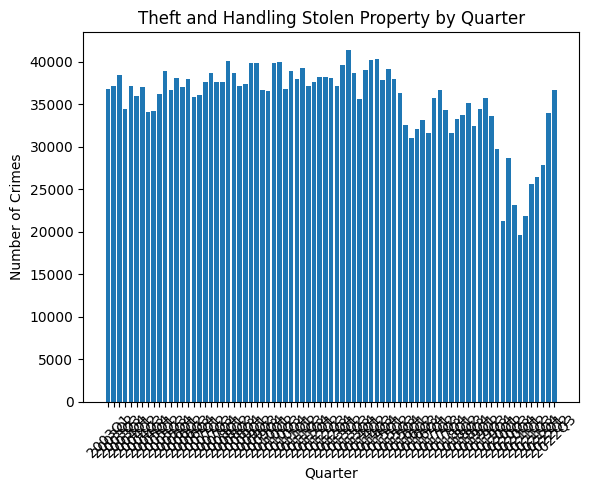

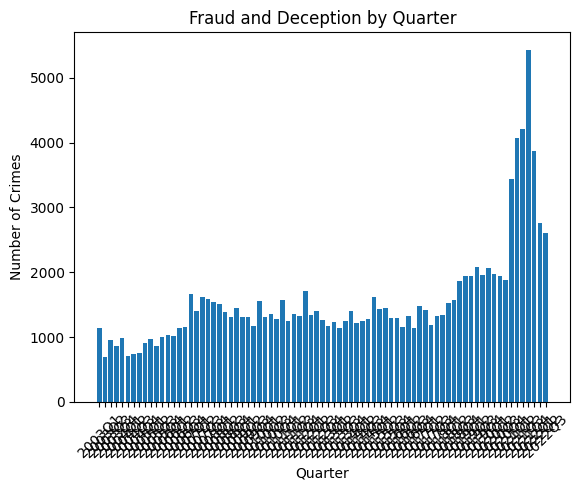

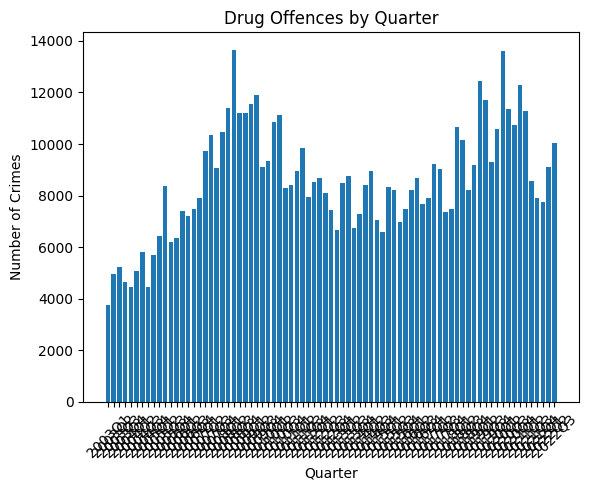

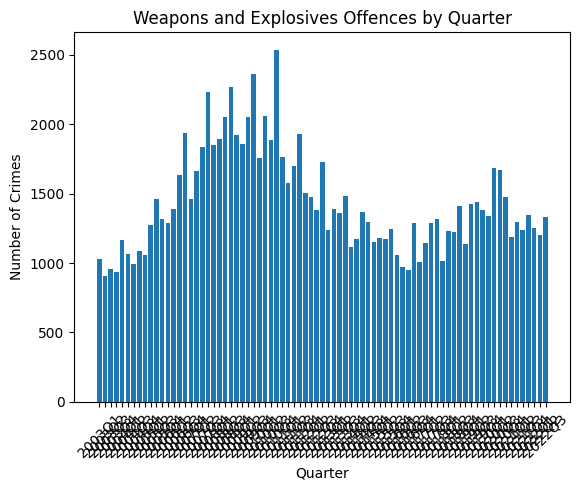

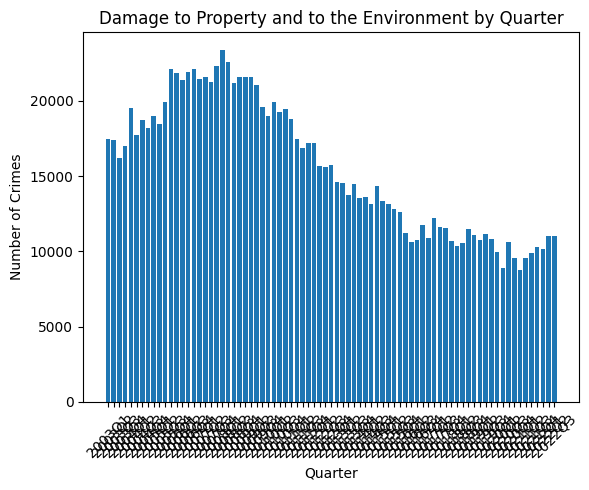

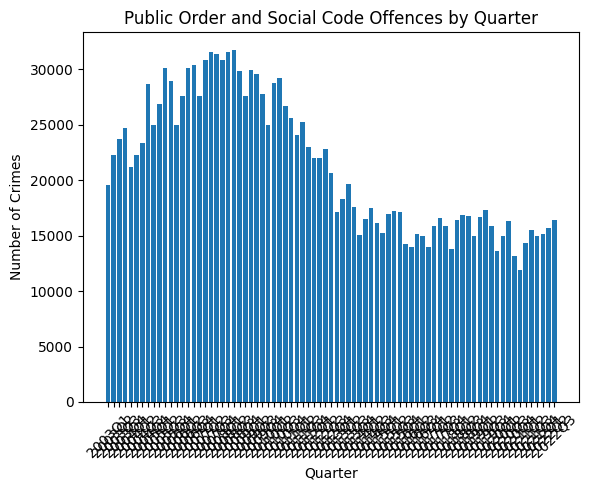

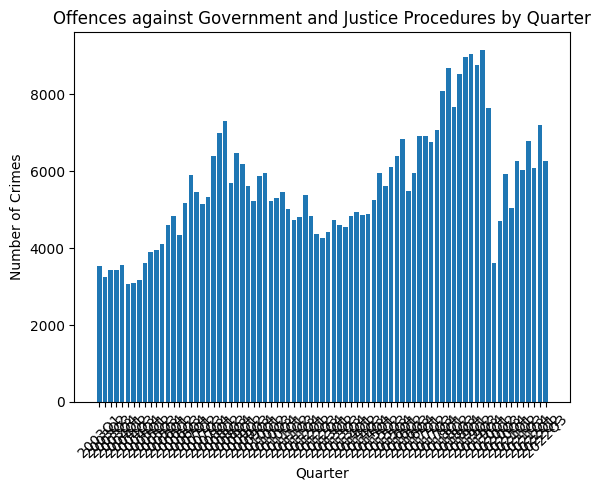

In [69]:
import matplotlib.pyplot as plt
def categorize_offence(offence):
    for category, offences in crime_dict.items():
        if offence in offences:
            return category
    return None
data['Category'] = data['Type of Offence'].apply(categorize_offence)

# Group by 'Category' and 'Quarter', and sum the '# Value' column
grouped_data = data.groupby(['Category', 'Quarter'])['VALUE'].sum().reset_index()

# Plot histograms for each category
for category in crime_dict.keys():
    category_data = grouped_data[grouped_data['Category'] == category]
    
    plt.figure()
    plt.bar(category_data['Quarter'], category_data['VALUE'])
    plt.title(f'{category} by Quarter')
    plt.xlabel('Quarter')
    plt.ylabel('Number of Crimes')
    plt.xticks(rotation=45)
    plt.show()

Doing the same as above but using years instead of quarters

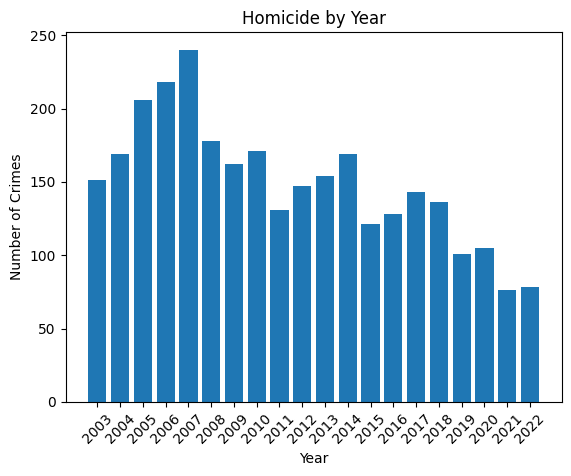

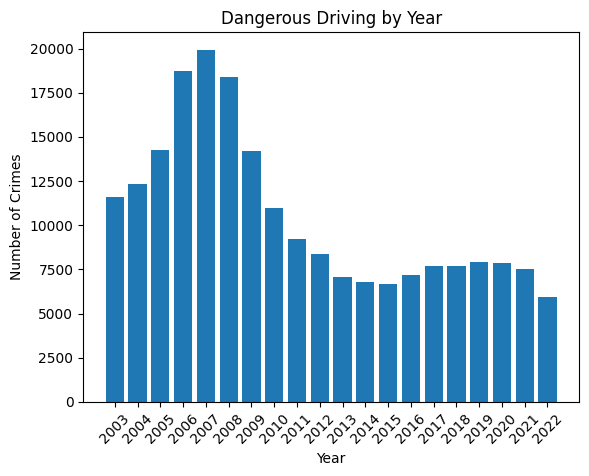

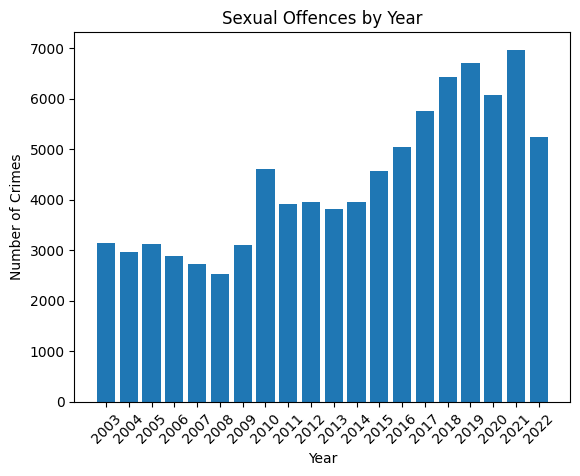

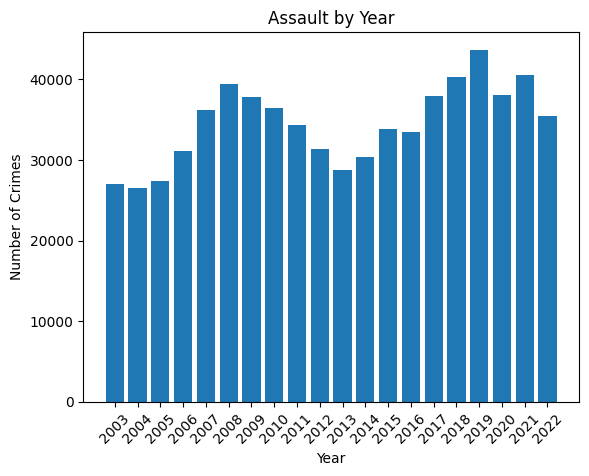

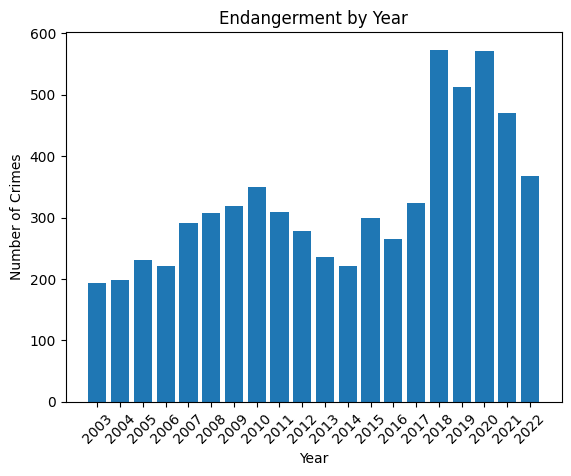

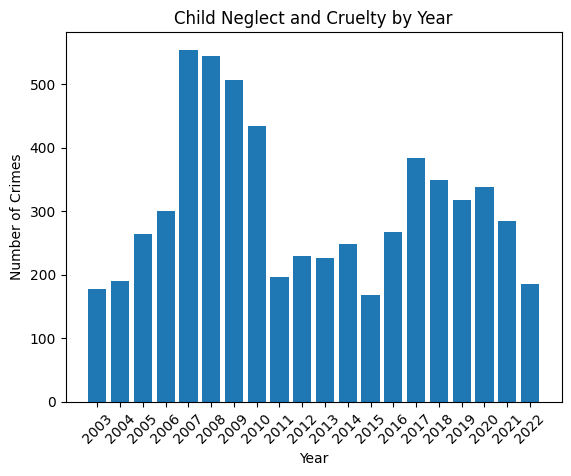

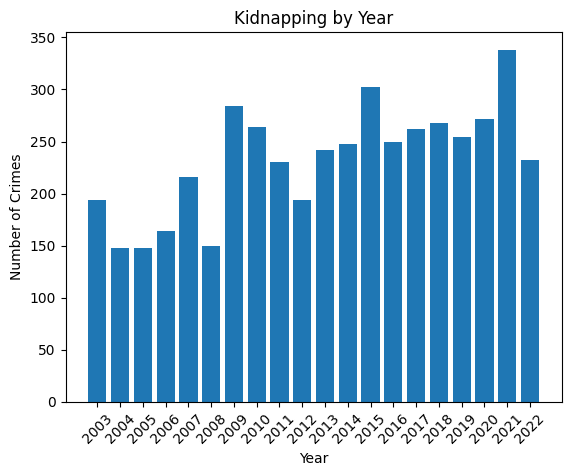

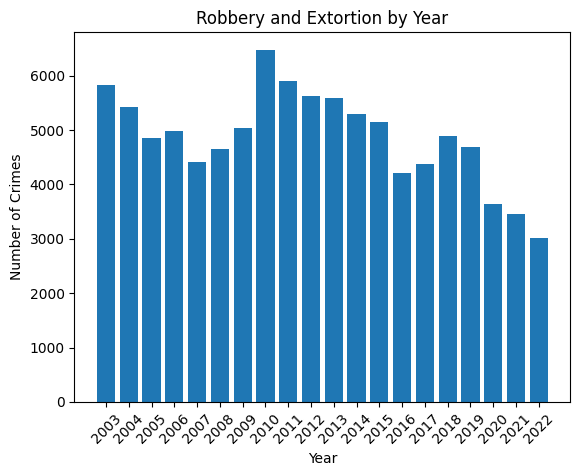

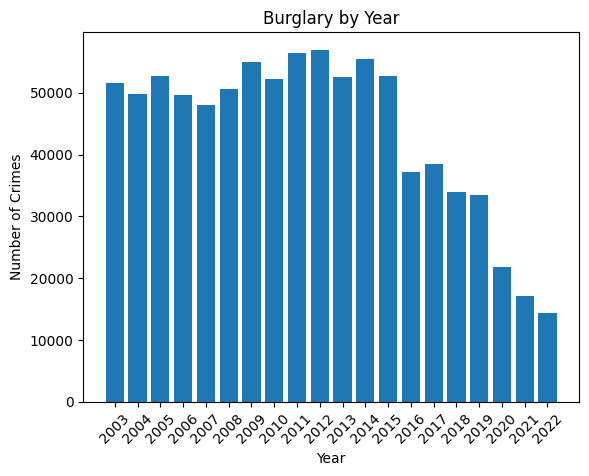

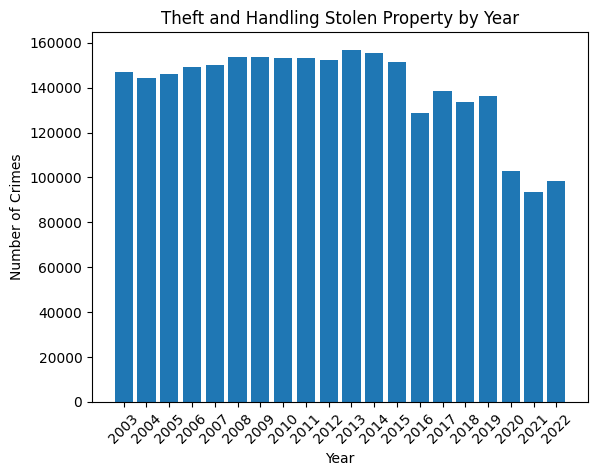

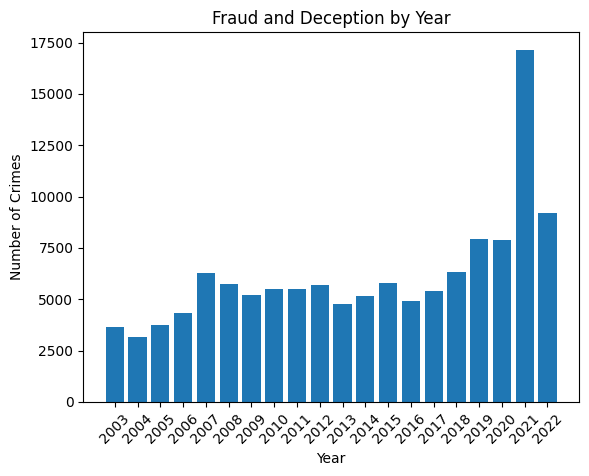

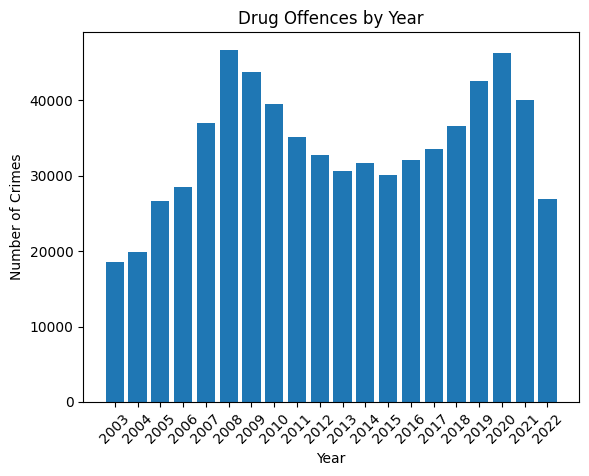

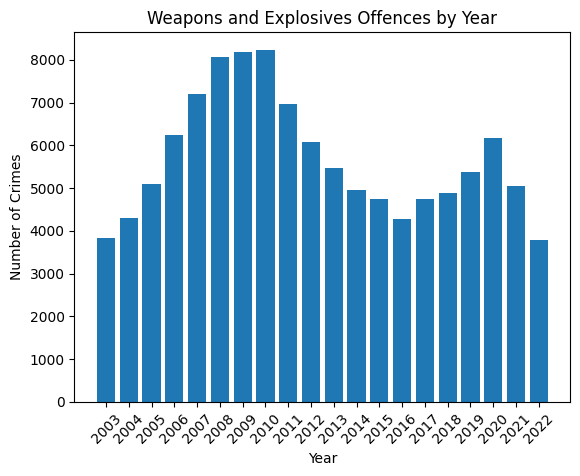

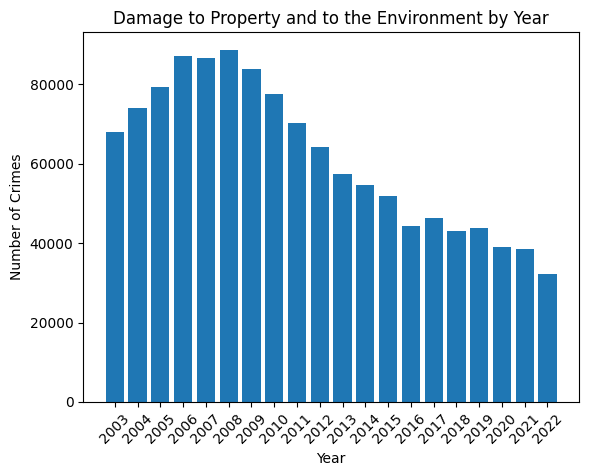

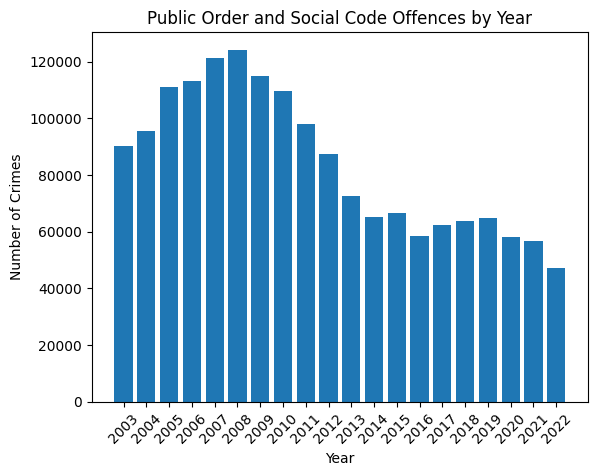

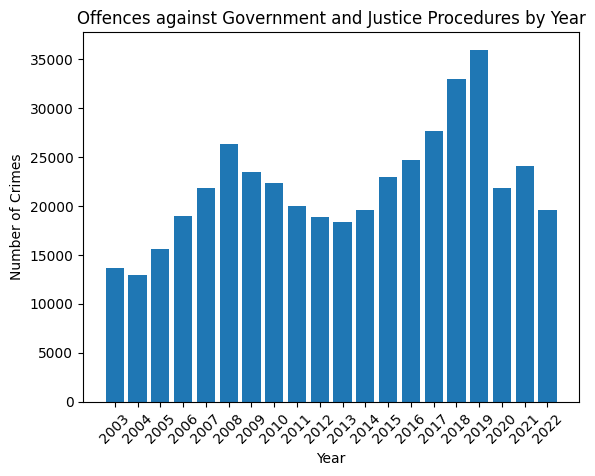

In [ ]:
import matplotlib.pyplot as plt

def categorize_offence(offence):
    for category, offences in crime_dict.items():
        if offence in offences:
            return category
    return None

data['Category'] = data['Type of Offence'].apply(categorize_offence)

# Extract the year from the 'Quarter' column when the format is like '2003Q1'
data['Year'] = data['Quarter'].str.extract('(\d{4})Q\d').astype(int)

# Group by 'Category' and 'Year', and sum the '# Value' column
grouped_data = data.groupby(['Category', 'Year'])['VALUE'].sum().reset_index()

# Plot histograms for each category
for category in crime_dict.keys():
    category_data = grouped_data[grouped_data['Category'] == category]
    
    plt.figure()
    plt.bar(category_data['Year'].astype(str), category_data['VALUE'])
    plt.title(f'{category} by Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Crimes')
    plt.xticks(rotation=45)
    plt.show()

We do the same as above except we zone in on covid and view the changes in crime rates of certain categories

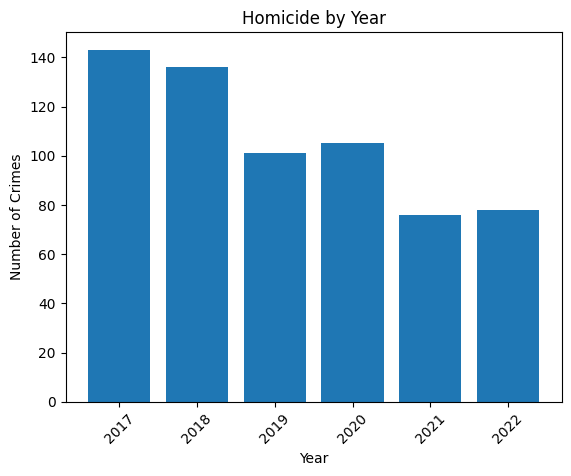

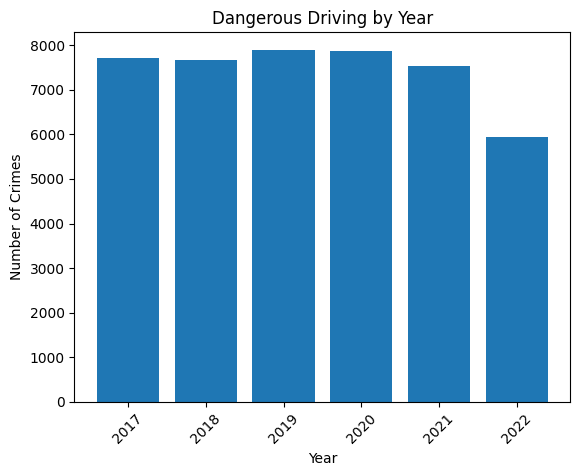

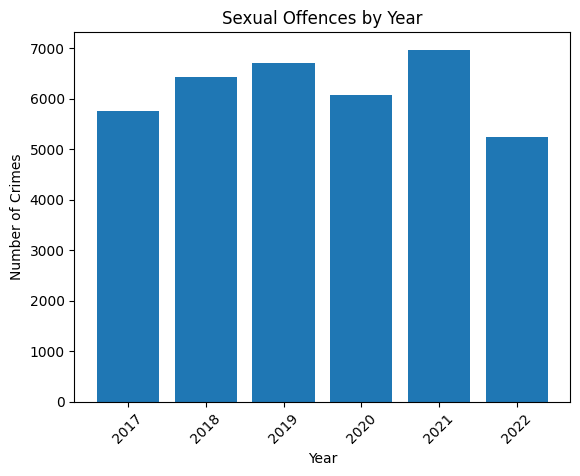

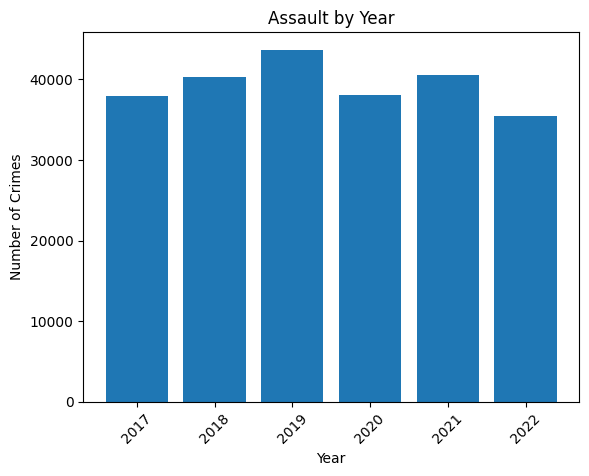

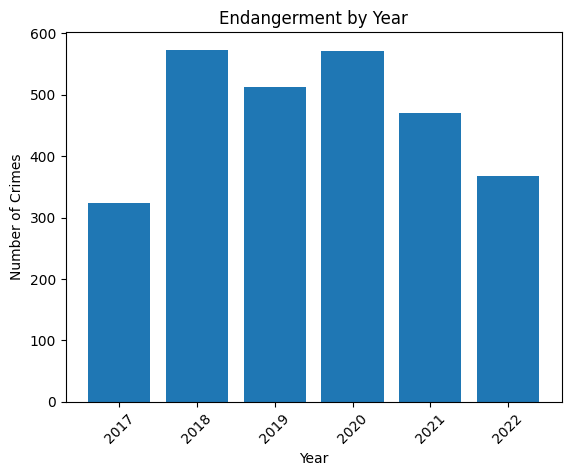

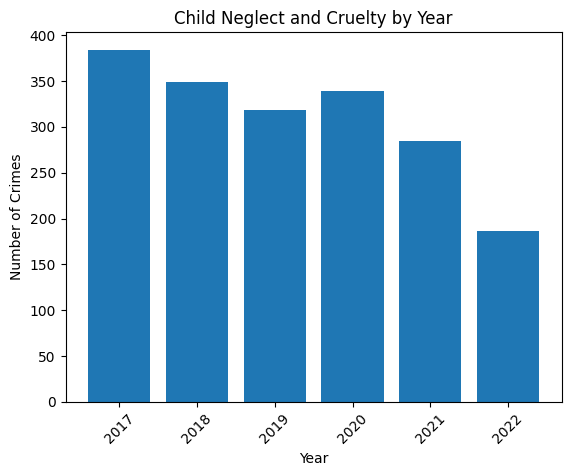

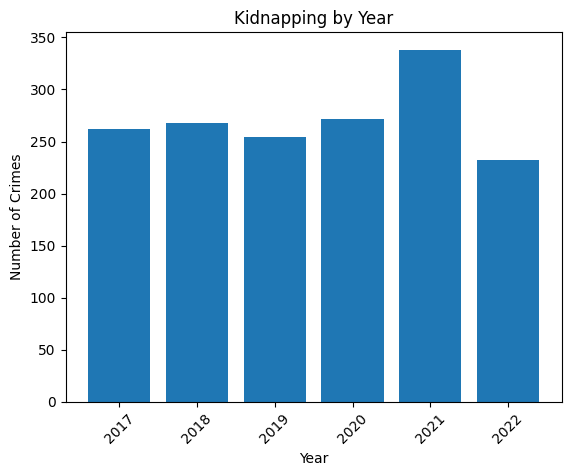

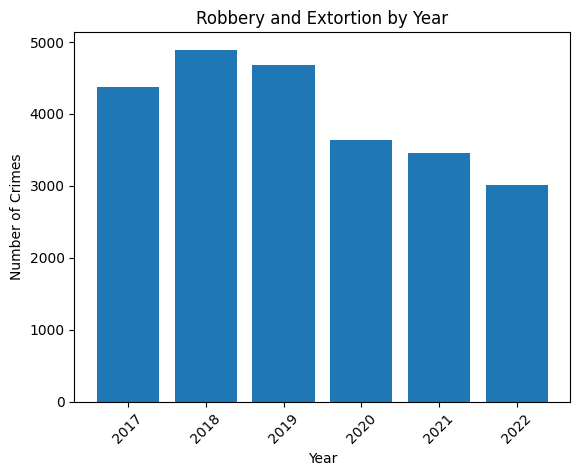

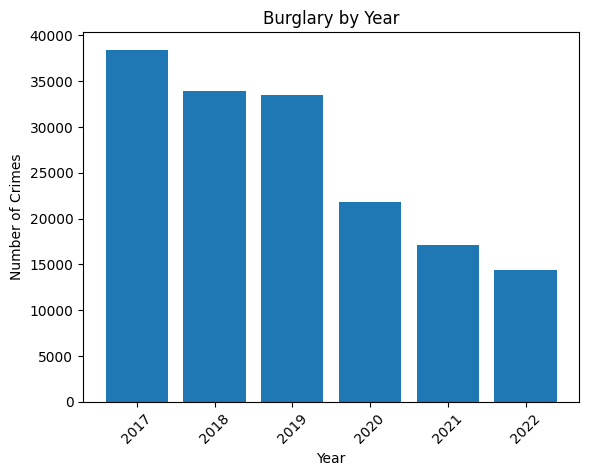

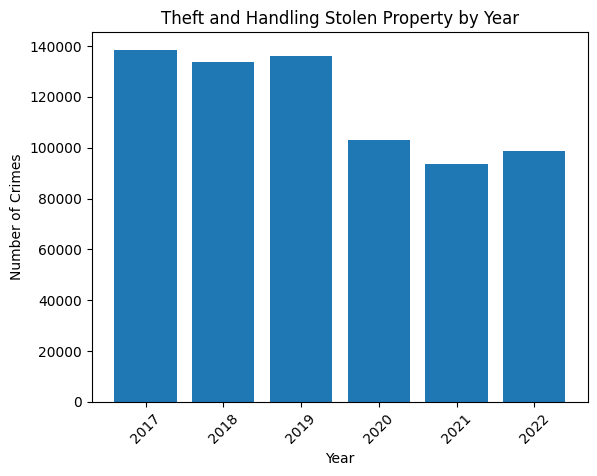

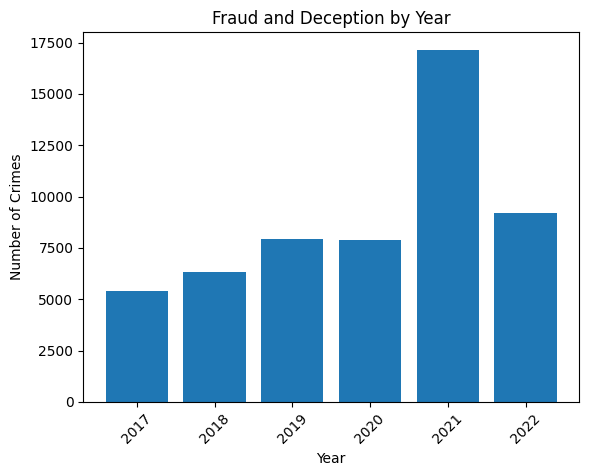

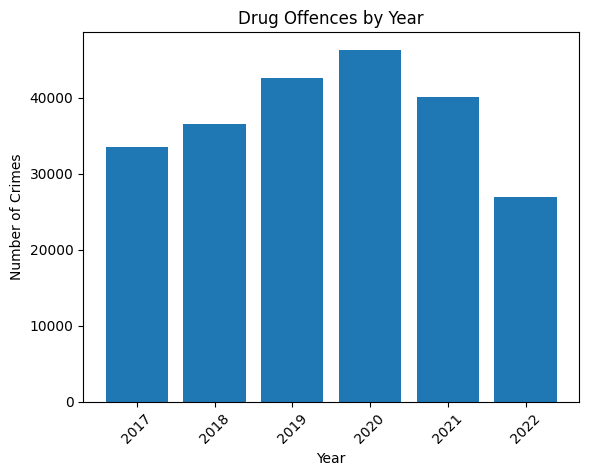

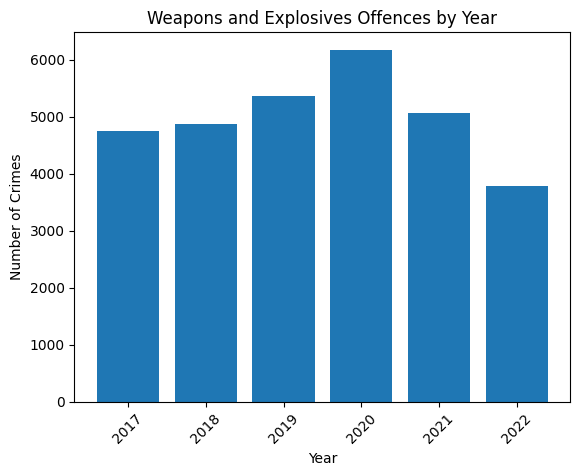

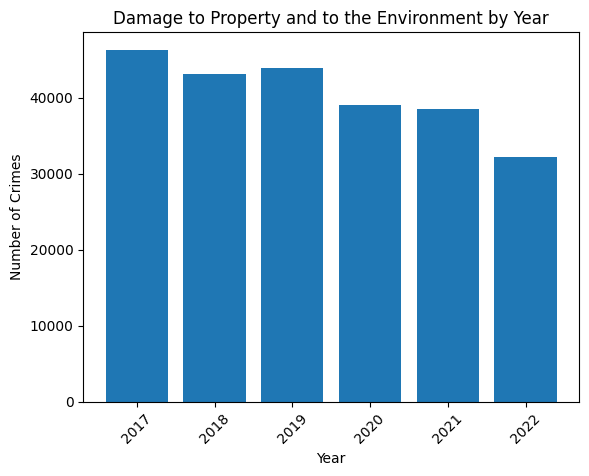

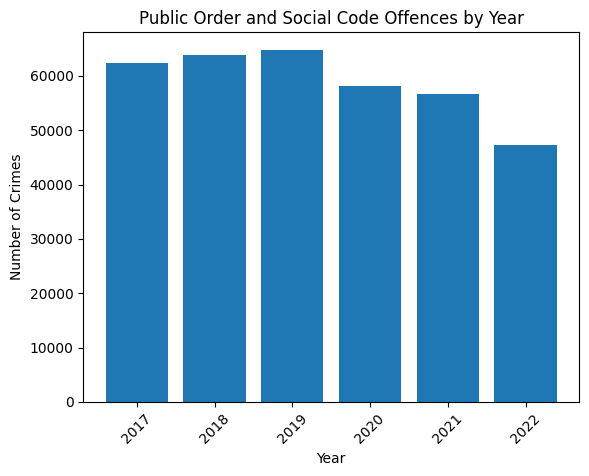

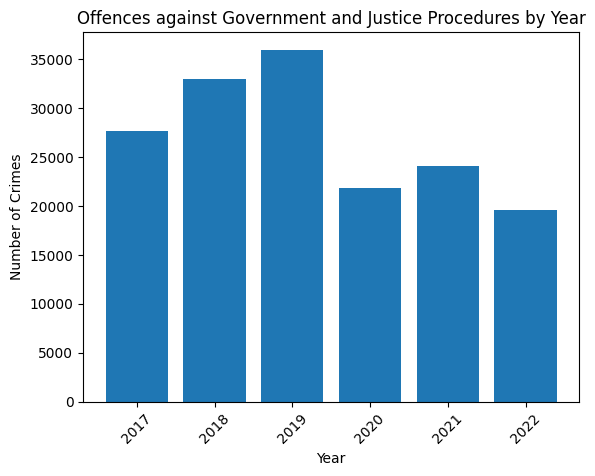

In [ ]:

import matplotlib.pyplot as plt

def categorize_offence(offence):
    for category, offences in crime_dict.items():
        if offence in offences:
            return category
    return None

data['Category'] = data['Type of Offence'].apply(categorize_offence)

# Extract the year from the 'Quarter' column when the format is like '2003Q1'
data['Year'] = data['Quarter'].str.extract('(\d{4})Q\d').astype(int)

# Group by 'Category' and 'Year', and sum the '# Value' column
grouped_data = grouped_data[(grouped_data['Year'] >= 2017) & (grouped_data['Year'] <= 2022)]

# Plot histograms for each category
for category in crime_dict.keys():
    category_data = grouped_data[grouped_data['Category'] == category]
    
    plt.figure()
    plt.bar(category_data['Year'].astype(str), category_data['VALUE'])
    plt.title(f'{category} by Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Crimes')
    plt.xticks(rotation=45)
    plt.show()

Here we are grouping relevant crimes by the categories to get a better view of the data

In [ ]:
crime_dict = {
    'Homicide': ['Homicide offences', 'Murder', 'Manslaughter', 'Infanticide'],
    'Dangerous Driving': ['Dangerous driving leading to death', 'Dangerous driving causing serious bodily harm', 'Driving/in charge of a vehicle while over legal alcohol limit', 'Driving/in charge of a vehicle under the influence of drugs'],
    'Sexual Offences': ['Sexual offences', 'Rape and sexual assault', 'Other sexual offences'],
    'Assault': ['Attempts/threats to murder, assaults, harassments and related offences', 'Murder-attempt', 'Threat to kill or cause serious harm', 'Harassment and related offences', 'Assault causing harm, poisoning', 'Other assault'],
    'Endangerment': ['Endangerment with potential for serious harm/death', 'Unseaworthy/dangerous use of boat or ship', 'Endangering traffic offences'],
    'Child Neglect and Cruelty': ['Abandoning a child, child neglect and cruelty'],
    'Kidnapping': ['Kidnapping and related offences', 'False imprisonment', 'Abduction of person under 16 years of age', 'Human trafficking offences'],
    'Robbery and Extortion': ['Robbery, extortion and hijacking offences', 'Robbery of an establishment or institution', 'Robbery of cash or goods in transit', 'Robbery from the person', 'Blackmail or extortion', 'Carjacking, hijacking/unlawful seizure of aircraft/vessel'],
    'Burglary': ['Burglary and related offences', 'Aggravated burglary', 'Burglary (not aggravated)', 'Possession of an article (with intent to burgle, steal, demand)'],
    'Theft and Handling Stolen Property': ['Theft and related offences', 'Theft/taking of vehicle and related offences', 'Theft from person', 'Theft from shop', 'Other thefts, handling stolen property'],
    'Fraud and Deception': ['Fraud, deception and related offences'],
    'Drug Offences': ['Controlled drug offences', 'Importation of drugs', 'Cultivation or manufacture of drugs', 'Possession of drugs for sale or supply', 'Possession of drugs for personal use', 'Other drug offences'],
    'Weapons and Explosives Offences': ['Weapons and Explosives Offences', 'Explosives, chemical weapons offences', 'Discharging a firearm', 'Possession of a firearm', 'Offensive weapons offences (n.e.c.)', 'Fireworks offences'],
    'Damage to Property and to the Environment': ['Damage to property and to the environment', 'Arson', 'Criminal damage (not arson)', 'Litter offences'],
    'Public Order and Social Code Offences': ['Public order and other social code offences', 'Disorderly conduct', 'Trespass offences', 'Liquor licensing offences', 'Prostitution offences', 'Regulated betting/money, collection/trading offences', 'Social code offences (n.e.c.)'],
    'Offences against Government and Justice Procedures': ['Offences against government, justice procedures and organisation of crime', 'Offences against government and its agents', 'Organisation of crime and conspiracy to commit crime', 'Perverting the course of justice', 'Offences while in custody, breach of court orders']
}

Here we are looking at the basic stats of the data

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
data = pd.read_csv("recorded_crime_ireland.csv")
data.describe()

,VALUE
count,157052.000000
mean,59.076675
std,150.331762
min,0.000000
25%,0.000000
50%,4.000000
75%,46.000000
max,2563.000000


Here we are pre-processing the data in preparation to perform a k-means analysis on the data. We are grouping the crime rates by the categories outlined above and then subsequently grouping by year

In [ ]:
import pandas as pd

data = pd.read_csv('recorded_crime_ireland.csv')
data['Year'] = data['Quarter'].apply(lambda x: int(x[:4]))
grouped_data = data.groupby(['Year', 'Type of Offence']).agg({'VALUE': 'sum'}).reset_index()
offence_to_category = {}
for category, offences in crime_dict.items():
    for offence in offences:
        offence_to_category[offence] = category
grouped_data['Category'] = grouped_data['Type of Offence'].map(offence_to_category)
final_data = grouped_data.groupby(['Year', 'Category']).agg({'VALUE': 'sum'}).reset_index()
pivoted_data = final_data.pivot(index='Year', columns='Category', values='VALUE').reset_index()
pivoted_data.fillna(0, inplace=True)  # Replace NaN values with 0

print(pivoted_data)


Category  Year  Assault  Burglary  Child Neglect and Cruelty   
0         2003    27070     51508                        178  \
1         2004    26548     49798                        191   
2         2005    27366     52742                        264   
3         2006    31116     49640                        300   
4         2007    36276     48022                        554   
5         2008    39430     50556                        544   
6         2009    37832     55040                        506   
7         2010    36466     52230                        434   
8         2011    34330     56416                        197   
9         2012    31414     56934                        229   
10        2013    28732     52624                        226   
11        2014    30338     55422                        248   
12        2015    33836     52638                        168   
13        2016    33440     37168                        267   
14        2017    37980     38412       

Let's look at the statistics from the above grouped data

In [ ]:
pivoted_data.describe()

Category,Year,Assault,Burglary,Child Neglect and Cruelty,Damage to Property and to the Environment,Dangerous Driving,Drug Offences,Endangerment,Fraud and Deception,Homicide,Kidnapping,Offences against Government and Justice Procedures,Public Order and Social Code Offences,Robbery and Extortion,Sexual Offences,Theft and Handling Stolen Property,Weapons and Explosives Offences
count,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,2012.50000,34522.900000,43995.300000,308.350000,61553.400000,10518.150000,33948.000000,326.950000,6169.300000,149.200000,233.000000,22090.900000,84085.800000,4874.300000,4373.000000,139944.100000,5683.800000
std,5.91608,4957.409743,13431.559964,120.955962,18657.078195,4399.816961,7867.267458,117.140705,2971.600209,42.908225,53.020354,5726.637058,25166.966058,865.027234,1421.424823,19519.637286,1409.106159
min,2003.00000,26548.000000,14408.000000,168.000000,32252.000000,5939.000000,18590.000000,194.000000,3176.000000,76.000000,148.000000,12912.000000,47256.000000,3012.000000,2538.000000,93576.000000,3786.000000
25%,2007.75000,30921.500000,36354.000000,218.750000,44212.500000,7451.500000,29687.000000,234.750000,4891.750000,126.250000,194.000000,18936.500000,63527.000000,4398.000000,3113.500000,135673.000000,4755.000000
50%,2012.50000,34926.000000,50177.000000,276.000000,60815.000000,8124.500000,33134.000000,303.500000,5502.000000,149.000000,245.000000,21856.000000,80179.000000,4934.000000,3948.500000,147924.000000,5239.000000
75%,2017.25000,38016.000000,52664.000000,357.750000,78052.500000,12810.250000,39692.000000,354.500000,6282.750000,169.500000,265.000000,24265.500000,110017.500000,5472.000000,5371.750000,153296.500000,6426.500000
max,2022.00000,43672.000000,56934.000000,554.000000,88686.000000,19928.000000,46708.000000,573.000000,17145.000000,240.000000,338.000000,35940.000000,124148.000000,6474.000000,6962.000000,156854.000000,8232.000000


Let's disregard the year since statistics shouldn't be relevant to the 'Year' column.

In [ ]:
selected_columns = [col for col in pivoted_data.columns if col != 'Year']
descriptive_stats = pivoted_data[selected_columns].describe()
print(descriptive_stats)

Category       Assault      Burglary  Child Neglect and Cruelty   
count        20.000000     20.000000                  20.000000  \
mean      34522.900000  43995.300000                 308.350000   
std        4957.409743  13431.559964                 120.955962   
min       26548.000000  14408.000000                 168.000000   
25%       30921.500000  36354.000000                 218.750000   
50%       34926.000000  50177.000000                 276.000000   
75%       38016.000000  52664.000000                 357.750000   
max       43672.000000  56934.000000                 554.000000   

Category  Damage to Property and to the Environment  Dangerous Driving   
count                                     20.000000          20.000000  \
mean                                   61553.400000       10518.150000   
std                                    18657.078195        4399.816961   
min                                    32252.000000        5939.000000   
25%                       

We need to get the col names in order to perform a min-max normalisation of the dataset

In [ ]:
pivoted_data.columns

Index(['Year', 'Assault', 'Burglary', 'Child Neglect and Cruelty',
       'Damage to Property and to the Environment', 'Dangerous Driving',
       'Drug Offences', 'Endangerment', 'Fraud and Deception', 'Homicide',
       'Kidnapping', 'Offences against Government and Justice Procedures',
       'Public Order and Social Code Offences', 'Robbery and Extortion',
       'Sexual Offences', 'Theft and Handling Stolen Property',
       'Weapons and Explosives Offences'],
      dtype='object', name='Category')

We are normalising the data using minmax function offered by the scikit-learn module (for ml). We could ahve used Z score normalisation but opted not to for simplicity. This is so we can remove outliers and any data abnormalities that might skew a k-mean analysis.

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

cols_to_normalize = [ 'Assault', 'Burglary', 'Child Neglect and Cruelty',
       'Damage to Property and to the Environment', 'Dangerous Driving',
       'Drug Offences', 'Endangerment', 'Fraud and Deception', 'Homicide',
       'Kidnapping', 'Offences against Government and Justice Procedures',
       'Public Order and Social Code Offences', 'Robbery and Extortion',
       'Sexual Offences', 'Theft and Handling Stolen Property',
       'Weapons and Explosives Offences']
scaler = MinMaxScaler()
normalized_cols = scaler.fit_transform(pivoted_data[cols_to_normalize])
pivoted_data[cols_to_normalize] = normalized_cols
print(pivoted_data)



Category  Year   Assault  Burglary  Child Neglect and Cruelty   
0         2003  0.030484  0.872407                   0.025907  \
1         2004  0.000000  0.832197                   0.059585   
2         2005  0.047769  0.901425                   0.248705   
3         2006  0.266760  0.828481                   0.341969   
4         2007  0.568092  0.790434                   1.000000   
5         2008  0.752278  0.850021                   0.974093   
6         2009  0.658958  0.955463                   0.875648   
7         2010  0.579187  0.889385                   0.689119   
8         2011  0.454450  0.987819                   0.075130   
9         2012  0.284163  1.000000                   0.158031   
10        2013  0.127540  0.898650                   0.150259   
11        2014  0.221327  0.964445                   0.207254   
12        2015  0.425601  0.898979                   0.000000   
13        2016  0.402476  0.535202                   0.256477   
14        2017  0.667601 

Here is the normalised data using z-score normalisation. Note: We will continue with the min-max method of normalisation from here on.

In [ ]:
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt


crime_rates_standardized = preprocessing.scale(pivoted_data)
print(crime_rates_standardized)
crime_rates_standardized = pd.DataFrame(crime_rates_standardized)

[[-1.64750894 -1.54244141  0.57386242 -1.1056609   0.35714697  0.25856896
  -2.0028524  -1.16444426 -0.87430502  0.04303979 -0.75467538 -1.5086797
   0.25259966  1.12403361 -0.88708694  0.36151166 -1.35121872]
 [-1.47408695 -1.65047377  0.44324297 -0.99539169  0.68863497  0.424831
  -1.84140356 -1.12941021 -1.03347045  0.4734377  -1.64480533 -1.6444822
   0.46768565  0.66146834 -1.02278453  0.23231588 -1.00027173]
 [-1.30066495 -1.48118168  0.66812231 -0.37618766  0.98327875  0.87254927
  -0.94626234 -0.84037929 -0.83908837  1.35814451 -1.64480533 -1.16756104
   1.0959846  -0.03356563 -0.90441004  0.32114455 -0.42069952]
 [-1.12724296 -0.7050871   0.43117404 -0.07082676  1.40913194  1.91489337
  -0.71569566 -0.92796442 -0.6322769   1.64507645 -1.33519491 -0.56057048
   1.18673164  0.12299492 -1.07619742  0.47735686  0.40934107]
 [-0.95382097  0.36281904  0.30758207  2.08366399  1.37459736  2.19425092
   0.40375251 -0.31486853  0.03614885  2.17111833 -0.32896107 -0.04674257
   1.5211830

This is used to see how many clusters we will implement to perform the k-means analysis. This is denoted as the 'Elbow method'. It is clear from the graph that it appears to start to level off around N = 3. WCSS stands for Within-Cluster Sum of Squares. It is a measure of the variance or spread of the data within each cluster. It measures the sum of the squared Euclidean distances between each data point and the centroid of its assigned cluster. For an efficient K-means algorithm we want to choose this carefully. You can see that adding more clusters will be 'better' however, this is a dire overfit of the data since intuitively, the more points the less variance (which will provide no meaningful insights into the data)

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_in

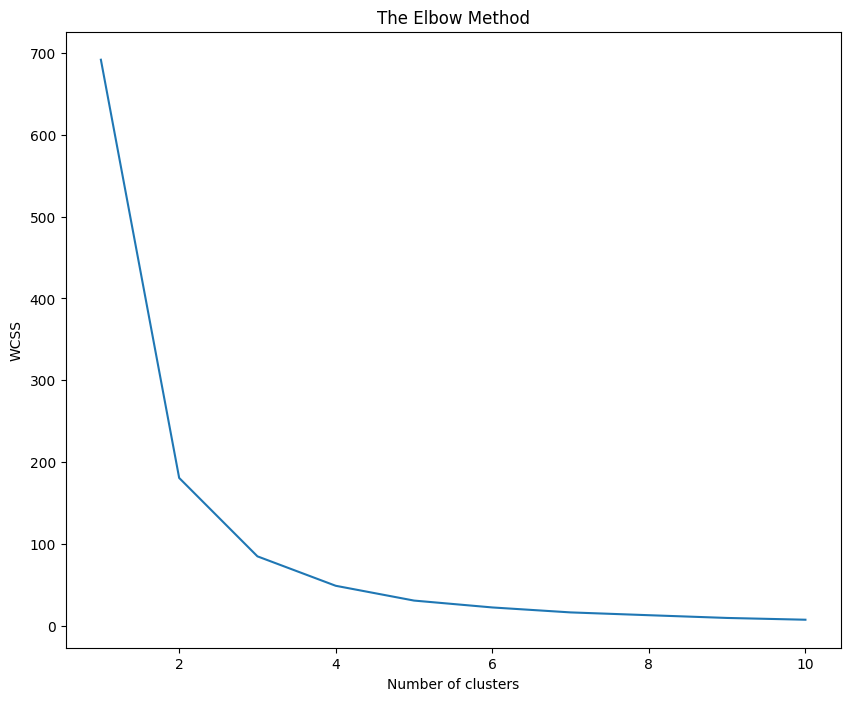

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 8))
wcss = [] # Within Cluster Sum of Squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 7)
    kmeans.fit(pivoted_data) # It is normalised at this stage - the cell two above has been ran before this 
    wcss.append(kmeans.inertia_) #criterion based on which K-means clustering works
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Here we are fitting the k-means algorithm with 3 clusters, the k-means++ method of initialisation (so that we don't run into a meaningless square) - all that means is we randomly choose the first cluster to pivot to and the random_state for the ability to reproduce this. We are then fitting the cols to the clusters which is the output - indicating which cluster they belong to.

In [ ]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 7)
y_kmeans = kmeans.fit_predict(pivoted_data)

y_kmeans

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1])

Here we are first adding one to the array as we don't want 0 to be a cluster rather '1'. Then we are adding this to our original dataset (in this case pivoted_data)

In [ ]:
y_kmeans1=y_kmeans+1
cluster = list(y_kmeans1)
pivoted_data['cluster'] = cluster

Here we are creating a download link to download the data. Note: the data is clustered by year. We want to identify the similar years through an unsupervised method.

In [ ]:
from IPython.display import HTML
import base64

df = pivoted_data
def create_download_link( df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(df)

Printing the head to see the best way of visualising this dataset

In [ ]:
pivoted_data.head

<bound method NDFrame.head of Category  Year   Assault  Burglary  Child Neglect and Cruelty   
0         2003  0.030484  0.872407                   0.025907  \
1         2004  0.000000  0.832197                   0.059585   
2         2005  0.047769  0.901425                   0.248705   
3         2006  0.266760  0.828481                   0.341969   
4         2007  0.568092  0.790434                   1.000000   
5         2008  0.752278  0.850021                   0.974093   
6         2009  0.658958  0.955463                   0.875648   
7         2010  0.579187  0.889385                   0.689119   
8         2011  0.454450  0.987819                   0.075130   
9         2012  0.284163  1.000000                   0.158031   
10        2013  0.127540  0.898650                   0.150259   
11        2014  0.221327  0.964445                   0.207254   
12        2015  0.425601  0.898979                   0.000000   
13        2016  0.402476  0.535202                   0.25647

Here we are using a technique called PCA to allow for 2d plotting. What it does is take the two features whihc accounted for the most variability in the data and creates a scatter plot based on those features. We have labelled it by year as that was the clustering. There seems to be some notable changes in the crime rates in the years 2009 and 2016. It would be interesting to see if there were any extraneous factors that led to this ?

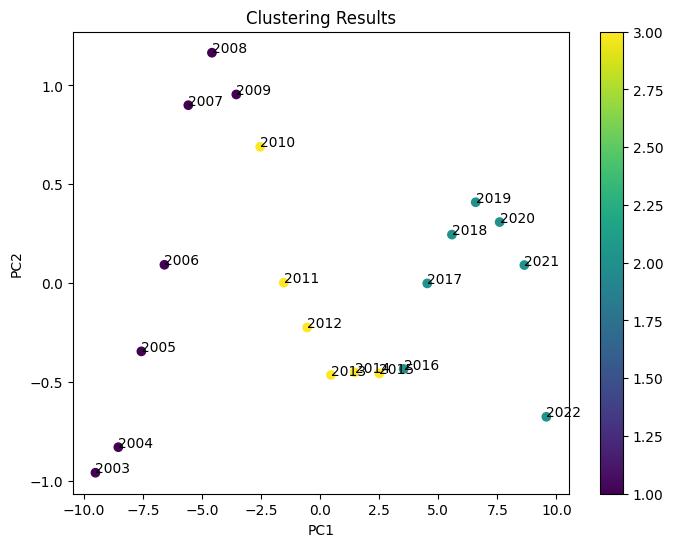

In [ ]:
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data_2d = pca.fit_transform(pivoted_data.iloc[:, :-1])  # Exclude the last column (cluster labels)

plt.figure(figsize=(8, 6))
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=pivoted_data['cluster'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering Results')

for i, year in enumerate(pivoted_data['Year']):
    plt.annotate(year, (data_2d[i, 0], data_2d[i, 1]))

plt.colorbar()
plt.show()


Here we are going to visualise the three data points 

First we will choose the most prominent features in our dataset and from visual inspection a lot of the crimes are grouped under the 'Burglary', 'Drug Offences' and 'Assualt' categories

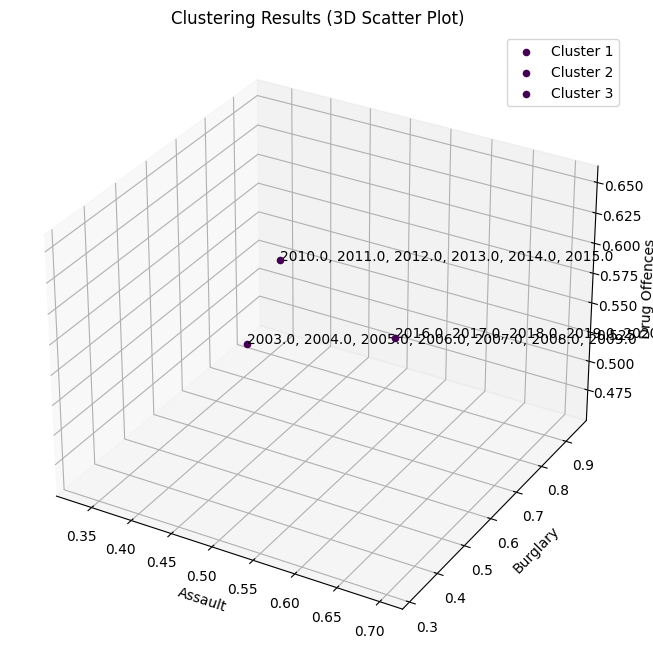

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

cluster_means = pivoted_data.groupby('cluster').mean()
year_values = pivoted_data.groupby('cluster').apply(lambda x: pd.Series(x['Year'].values))
year_values = year_values.unstack()


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for i, cluster in enumerate(cluster_means.index):
    ax.scatter(cluster_means.loc[cluster, 'Assault'], cluster_means.loc[cluster, 'Burglary'], cluster_means.loc[cluster, 'Drug Offences'], c=cluster_means.index[i], label=f'Cluster {cluster}')
    year_label = ', '.join(str(y) for y in year_values.loc[cluster].dropna().values)
    ax.text(cluster_means.loc[cluster, 'Assault'], cluster_means.loc[cluster, 'Burglary'], cluster_means.loc[cluster, 'Drug Offences'], year_label, fontsize=10)

ax.set_xlabel('Assault')
ax.set_ylabel('Burglary')
ax.set_zlabel('Drug Offences')
ax.set_title('Clustering Results (3D Scatter Plot)')

plt.legend()

plt.show()


The three most varying features (judged by standard deviation)

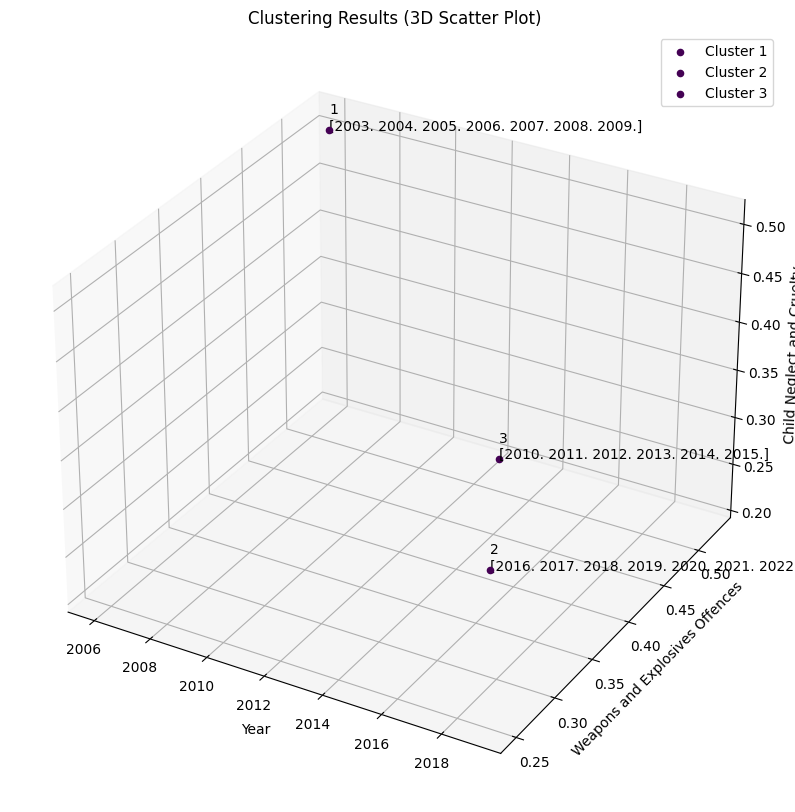

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

cluster_std = pivoted_data.groupby('cluster').std()
category_names = cluster_std.mean().sort_values(ascending=False)[:3].index

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
for i, cluster in enumerate(cluster_means.index):
    ax.scatter(cluster_means.loc[cluster, category_names[0]], cluster_means.loc[cluster, category_names[1]], cluster_means.loc[cluster, category_names[2]], c=cluster_means.index[i], label=f'Cluster {cluster}')
    ax.text(cluster_means.loc[cluster, category_names[0]], cluster_means.loc[cluster, category_names[1]], cluster_means.loc[cluster, category_names[2]], f'{cluster_means.index[i]}\n{year_values.loc[cluster].dropna().values}', fontsize=10)

ax.set_xlabel(category_names[0])
ax.set_ylabel(category_names[1])
ax.set_zlabel(category_names[2])
ax.set_title('Clustering Results (3D Scatter Plot)')

plt.legend()

plt.show()


The three least varying features (judged by standard deviation)

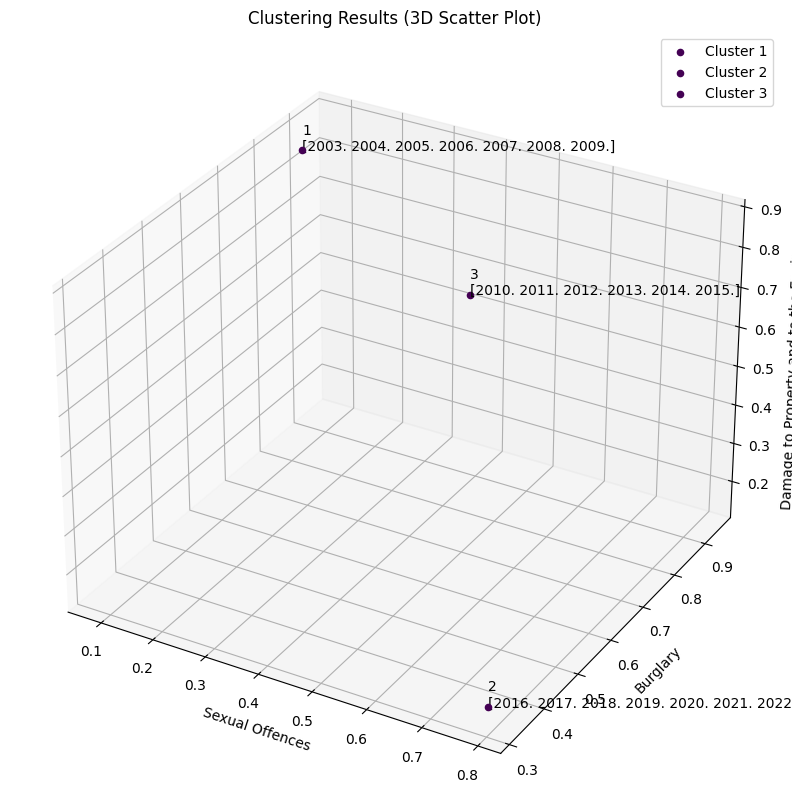

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

cluster_std = pivoted_data.groupby('cluster').std()
category_names = cluster_std.mean().sort_values(ascending=True)[:3].index

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
for i, cluster in enumerate(cluster_means.index):
    ax.scatter(cluster_means.loc[cluster, category_names[0]], cluster_means.loc[cluster, category_names[1]], cluster_means.loc[cluster, category_names[2]], c=cluster_means.index[i], label=f'Cluster {cluster}')
    ax.text(cluster_means.loc[cluster, category_names[0]], cluster_means.loc[cluster, category_names[1]], cluster_means.loc[cluster, category_names[2]], f'{cluster_means.index[i]}\n{year_values.loc[cluster].dropna().values}', fontsize=10)

ax.set_xlabel(category_names[0])
ax.set_ylabel(category_names[1])
ax.set_zlabel(category_names[2])
ax.set_title('Clustering Results (3D Scatter Plot)')

plt.legend()

plt.show()


We can repeat the same analysis above done on crime type instead of by year. Let's print the head to see where we are and drop the old cluster columns

Remove year col 

In [ ]:
pivoted_data = pivoted_data.drop('cluster', axis=1)

In [ ]:
pivoted_data = pivoted_data.drop('Year', axis=1)

Let's transpose the data so we are working with the type of crime as the index and not the year

In [ ]:

pivoted_data_transpose = pivoted_data.transpose()
pivoted_data_transpose.head

<bound method NDFrame.head of                                                           0         1    
Category                                                                 
Assault                                             0.030484  0.000000  \
Burglary                                            0.872407  0.832197   
Child Neglect and Cruelty                           0.025907  0.059585   
Damage to Property and to the Environment           0.634298  0.741114   
Dangerous Driving                                   0.406605  0.457574   
Drug Offences                                       0.000000  0.044029   
Endangerment                                        0.000000  0.010554   
Fraud and Deception                                 0.033002  0.000000   
Homicide                                            0.457317  0.567073   
Kidnapping                                          0.242105  0.000000   
Offences against Government and Justice Procedures  0.032916  0.000000   
Public O

Elbow Method yields 4 clusters as the most optimal

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_in

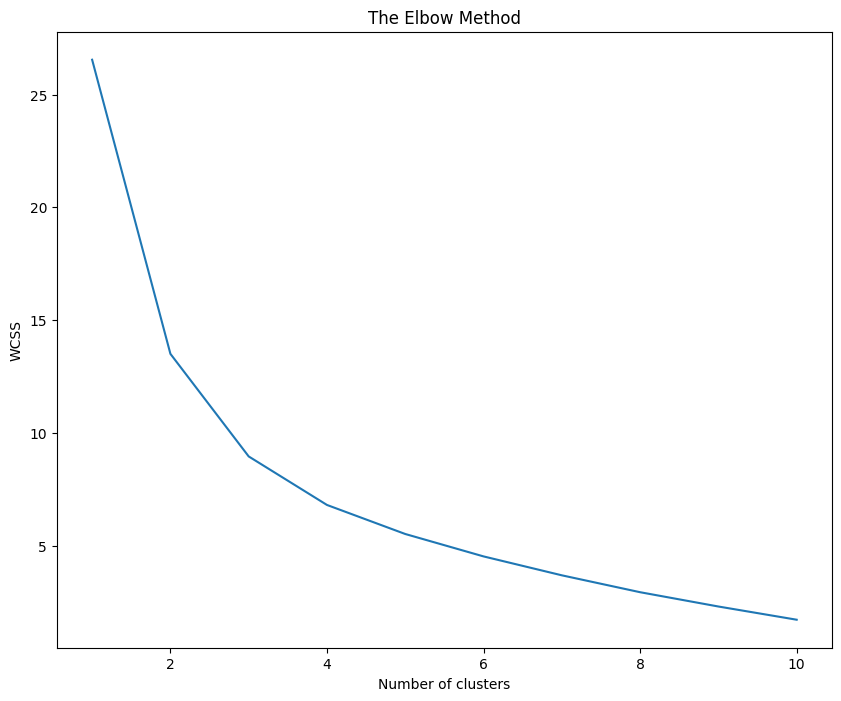

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 8))
wcss = [] # Within Cluster Sum of Squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 7)
    kmeans.fit(pivoted_data_transpose) # It is normalised at this stage - the cell above has been ran before this 
    wcss.append(kmeans.inertia_) #criterion based on which K-means clustering works
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 7)
y_kmeans = kmeans.fit_predict(pivoted_data_transpose)

y_kmeans

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([1, 3, 0, 2, 2, 0, 1, 1, 2, 1, 1, 2, 3, 1, 3, 0])

In [ ]:
y_kmeans1=y_kmeans+1
cluster = list(y_kmeans1)
pivoted_data_transpose['cluster'] = cluster

In [ ]:
from IPython.display import HTML
import base64

df = pivoted_data_transpose
def create_download_link( df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(df)

This is interesting to see. Drugs and weapons are similar and behave very similarly to each other -> More drugs leads to higher volumes of weapon offences

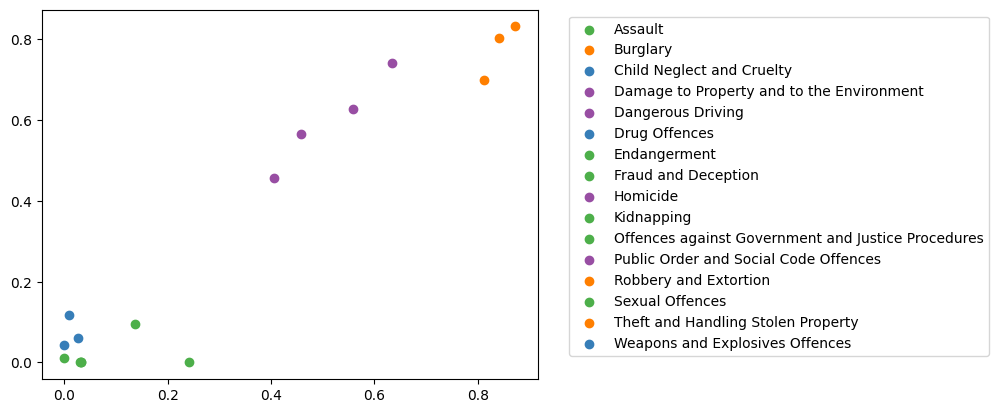

In [ ]:
import matplotlib.pyplot as plt

category_names = pivoted_data_transpose.index.tolist()
colors = pivoted_data_transpose['cluster'].tolist()

fig, ax = plt.subplots()
for i in range(len(category_names)):
    x = pivoted_data_transpose.loc[category_names[i], 0]
    y = pivoted_data_transpose.loc[category_names[i], 1]
    ax.scatter(x, y, color=plt.cm.Set1(colors[i]), label=category_names[i])
    
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Let's plot this as parallel coordinates to visualise the individual features

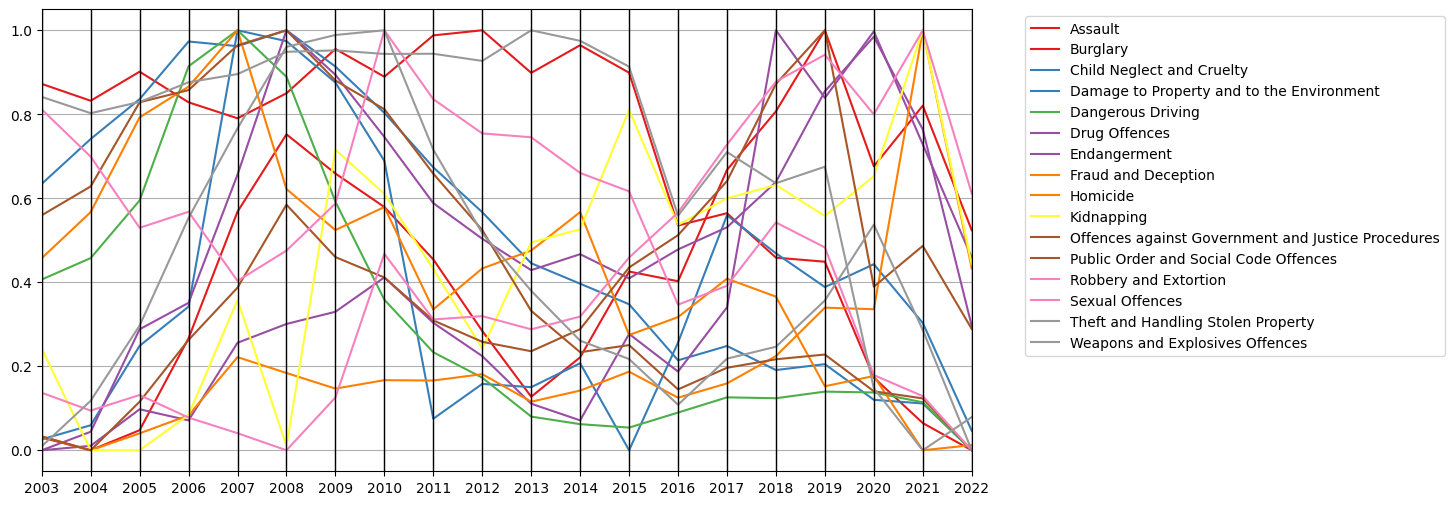

In [ ]:
import pandas as pd
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt

# Assume pivoted_data_transpose is a Pandas DataFrame with the PCA results and cluster labels
# Assume category_names is a list of category names in the same order as in pivoted_data_transpose
category_names = ['Assault', 'Burglary', 'Child Neglect and Cruelty',
       'Damage to Property and to the Environment', 'Dangerous Driving',
       'Drug Offences', 'Endangerment', 'Fraud and Deception', 'Homicide',
       'Kidnapping', 'Offences against Government and Justice Procedures',
       'Public Order and Social Code Offences', 'Robbery and Extortion',
       'Sexual Offences', 'Theft and Handling Stolen Property',
       'Weapons and Explosives Offences']
class_column = 'cluster'

# Drop the 'cluster' column if it exists
if class_column in pivoted_data_transpose.columns:
    pivoted_data_transpose = pivoted_data_transpose.drop(class_column, axis=1)

# Add the class column back to the DataFrame
pivoted_data_transpose[class_column] = pivoted_data_transpose.index.map(lambda x: category_names.index(x))

# Replace the class labels with the category names
pivoted_data_transpose[class_column] = pivoted_data_transpose[class_column].replace(dict(enumerate(category_names)))

# Create the parallel coordinates plot
fig, ax = plt.subplots(figsize=(12, 6))
parallel_coordinates(pivoted_data_transpose, class_column=class_column, colormap='Set1')
ax.set_xticklabels(['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022'])

ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()


We need to reset the cluster col back to the original (we use the same random_state to achieve this)

In [ ]:
pivoted_data_transpose = pivoted_data_transpose.drop('cluster', axis=1)

In [ ]:
pivoted_data_transpose.columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype='object')

In [ ]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 7)
y_kmeans = kmeans.fit_predict(pivoted_data_transpose)

y_kmeans

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([1, 3, 0, 2, 2, 0, 1, 1, 2, 1, 1, 2, 3, 1, 3, 0])

In [ ]:
y_kmeans1=y_kmeans+1
cluster = list(y_kmeans1)
pivoted_data_transpose['cluster'] = cluster

We will now visualise the parallel lines to visualise it by cluster as deemed by the k-means algorithm

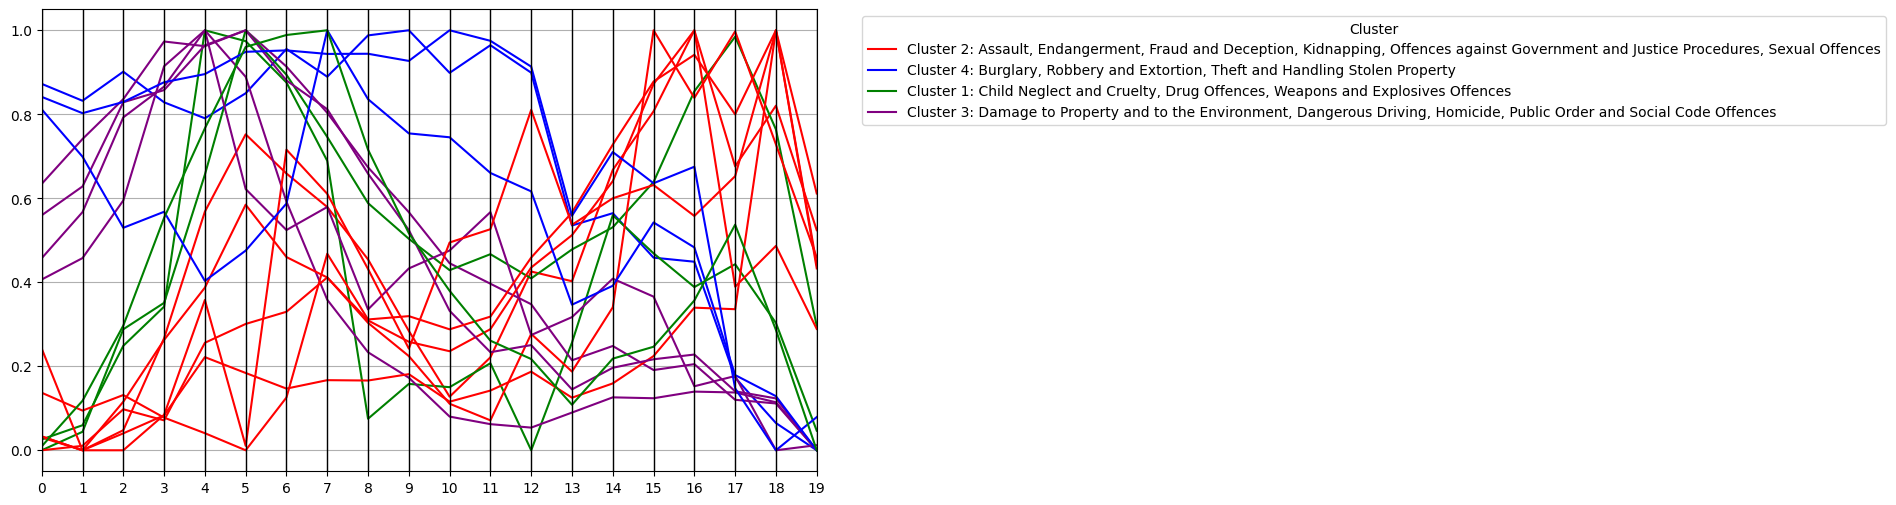

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pandas.plotting import parallel_coordinates

def get_categories_by_cluster(pivoted_data_transpose):
    categories_by_cluster = {}
    for i in range(len(pivoted_data_transpose)):
        cluster = pivoted_data_transpose.iloc[i, -1]
        category = pivoted_data_transpose.index[i]
        if cluster not in categories_by_cluster:
            categories_by_cluster[cluster] = []
        categories_by_cluster[cluster].append(str(category))
    result = [f'Cluster {i}: {", ".join(categories)}' for i, categories in categories_by_cluster.items()]
    return result

cmap = colors.ListedColormap(['red', 'blue', 'green', 'purple'])

fig, ax = plt.subplots(figsize=(10, 6))

parallel_coordinates(pivoted_data_transpose, 'cluster', ax=ax, colormap=cmap)

handles, labels = ax.get_legend_handles_labels()
cluster_labels = ['Cluster ' + str(i + 1) for i in range(len(labels))]
category_labels = [', '.join(pivoted_data_transpose.index[pivoted_data_transpose['cluster']==i]) for i in range(len(labels))]
legend_labels = get_categories_by_cluster(pivoted_data_transpose)
ax.legend(title='Cluster', labels=legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [ ]:
crime_dict = {
    'Homicide': ['Homicide offences', 'Murder', 'Manslaughter', 'Infanticide'],
    'Dangerous Driving': ['Dangerous driving leading to death', 'Dangerous driving causing serious bodily harm', 'Driving/in charge of a vehicle while over legal alcohol limit', 'Driving/in charge of a vehicle under the influence of drugs'],
    'Sexual Offences': ['Sexual offences', 'Rape and sexual assault', 'Other sexual offences'],
    'Assault': ['Attempts/threats to murder, assaults, harassments and related offences', 'Murder-attempt', 'Threat to kill or cause serious harm', 'Harassment and related offences', 'Assault causing harm, poisoning', 'Other assault'],
    'Endangerment': ['Endangerment with potential for serious harm/death', 'Unseaworthy/dangerous use of boat or ship', 'Endangering traffic offences'],
    'Child Neglect and Cruelty': ['Abandoning a child, child neglect and cruelty'],
    'Kidnapping': ['Kidnapping and related offences', 'False imprisonment', 'Abduction of person under 16 years of age', 'Human trafficking offences'],
    'Robbery and Extortion': ['Robbery, extortion and hijacking offences', 'Robbery of an establishment or institution', 'Robbery of cash or goods in transit', 'Robbery from the person', 'Blackmail or extortion', 'Carjacking, hijacking/unlawful seizure of aircraft/vessel'],
    'Burglary': ['Burglary and related offences', 'Aggravated burglary', 'Burglary (not aggravated)', 'Possession of an article (with intent to burgle, steal, demand)'],
    'Theft and Handling Stolen Property': ['Theft and related offences', 'Theft/taking of vehicle and related offences', 'Theft from person', 'Theft from shop', 'Other thefts, handling stolen property'],
    'Fraud and Deception': ['Fraud, deception and related offences'],
    'Drug Offences': ['Controlled drug offences', 'Importation of drugs', 'Cultivation or manufacture of drugs', 'Possession of drugs for sale or supply', 'Possession of drugs for personal use', 'Other drug offences'],
    'Weapons and Explosives Offences': ['Weapons and Explosives Offences', 'Explosives, chemical weapons offences', 'Discharging a firearm', 'Possession of a firearm', 'Offensive weapons offences (n.e.c.)', 'Fireworks offences'],
    'Damage to Property and to the Environment': ['Damage to property and to the environment', 'Arson', 'Criminal damage (not arson)', 'Litter offences'],
    'Public Order and Social Code Offences': ['Public order and other social code offences', 'Disorderly conduct', 'Trespass offences', 'Liquor licensing offences', 'Prostitution offences', 'Regulated betting/money, collection/trading offences', 'Social code offences (n.e.c.)'],
    'Offences against Government and Justice Procedures': ['Offences against government, justice procedures and organisation of crime', 'Offences against government and its agents', 'Organisation of crime and conspiracy to commit crime', 'Perverting the course of justice', 'Offences while in custody, breach of court orders']
}



Let's try to predict crime rates in certain geographic areas using some ml techniques and libraries

First, we must prepare the data so that we can train a model. This involves dividing up the different crime categories by geographic region

In [ ]:
import pandas as pd

unprocessed_data = pd.read_csv('recorded_crime_ireland.csv')
unprocessed_data['Quarter'] = pd.to_datetime(unprocessed_data['Quarter'].str.replace('Q', '-'), format='%Y-%m')
unprocessed_data.set_index('Quarter', inplace=True)
unprocessed_data.index = unprocessed_data.index.to_period('Y').to_timestamp()

crime_category = {subcat: cat for cat, subcats in crime_dict.items() for subcat in subcats} # Inverting the dictionary
unprocessed_data['Category'] = unprocessed_data['Type of Offence'].replace(crime_category)
agg_data = unprocessed_data.groupby(['Garda Division', 'Category', pd.Grouper(freq='Y')])['VALUE'].sum().reset_index()
agg_data['Year'] = agg_data['Quarter'].dt.year
agg_data.drop('Quarter', axis=1, inplace=True)
agg_data


,Garda Division,Category,VALUE,Year
0,Cavan/Monaghan Garda Division,Assault,1192,2003
1,Cavan/Monaghan Garda Division,Assault,1260,2004
2,Cavan/Monaghan Garda Division,Assault,1352,2005
3,Cavan/Monaghan Garda Division,Assault,1442,2006
4,Cavan/Monaghan Garda Division,Assault,1628,2007
...,...,...,...,...
10075,Wicklow Garda Division,Weapons and Explosives Offences,76,2018
10076,Wicklow Garda Division,Weapons and Explosives Offences,56,2019
10077,Wicklow Garda Division,Weapons and Explosives Offences,112,2020
10078,Wicklow Garda Division,Weapons and Explosives Offences,74,2021


Now we are going to preprocess the data, dividing it into train and test sets and fitting the encoders

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

garda_station_encoder = LabelEncoder()
category_encoder = LabelEncoder()

agg_data['Garda Division'] = garda_station_encoder.fit_transform(agg_data['Garda Division'])
agg_data['Category'] = category_encoder.fit_transform(agg_data['Category'])

X = agg_data[['Garda Division', 'Category', 'Year']]
y = agg_data['VALUE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

Let's train the model

In [ ]:
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1)#Push to maximum number of GPUs available -- Set processing to GPU from CPU on VSCode
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Let's evaluate the performance of the model. The model is wrong by about 139 units on average which is quite high. However, further optimisation could reduce this figure down significantly. The model's evaluation indicates that it has substantial errors in it - which is assumed since the data is number one: not large enough to form any sort of accurate model inference and number 2: heavily subject to external factors 

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

Mean Absolute Error: 139.9889500051818
Mean Squared Error: 78833.8395773654
Root Mean Squared Error: 280.7736447342688


Let's make an inference

In [ ]:
import itertools
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

garda_division_encoder = LabelEncoder()
category_encoder = LabelEncoder()

garda_divisions = ['Cavan/Monaghan Garda Division', 'Donegal Garda Division',
       'Sligo/Leitrim Garda Division', 'Louth Garda Division',
       'Clare Garda Division', 'Mayo Garda Division',
       'Galway Garda Division', 'Roscommon/Longford Garda Division',
       'Cork City Garda Division', 'Cork North Garda Division',
       'Cork West Garda Division', 'Kerry Garda Division',
       'Limerick Garda Division', 'Laois/Offaly Garda Division',
       'Meath Garda Division', 'Wicklow Garda Division',
       'Westmeath Garda Division', 'Kildare Garda Division',
       'Tipperary Garda Division', 'Wexford Garda Division',
       'Kilkenny/Carlow Garda Division', 'Waterford Garda Division',
       'D.M.R. South Central Garda Division',
       'D.M.R. North Central Garda Division',
       'D.M.R. Northern Garda Division', 'D.M.R. Southern Garda Division',
       'D.M.R. Eastern Garda Division', 'D.M.R. Western Garda Division']

categories = list(crime_dict.keys())
combinations = list(itertools.product(garda_divisions, categories))
predictions_df = pd.DataFrame(combinations, columns=['Garda Division', 'Category'])
predictions_df['Year'] = 2024

garda_division_encoder.fit(X_train['Garda Division'])
category_encoder.fit(X_train['Category'])

predictions_df_encoded = predictions_df.copy()
predictions_df_encoded['Garda Division'] = garda_division_encoder.fit_transform(predictions_df_encoded['Garda Division'])
predictions_df_encoded['Category'] = category_encoder.fit_transform(predictions_df_encoded['Category'])

predictions = model.predict(predictions_df_encoded)

predictions_df['Predicted Crimes'] = predictions

predictions = np.clip(predictions, 0, None)
predictions_df['Predicted Crimes'] = predictions
print(predictions_df)


                    Garda Division   
0    Cavan/Monaghan Garda Division  \
1    Cavan/Monaghan Garda Division   
2    Cavan/Monaghan Garda Division   
3    Cavan/Monaghan Garda Division   
4    Cavan/Monaghan Garda Division   
..                             ...   
443  D.M.R. Western Garda Division   
444  D.M.R. Western Garda Division   
445  D.M.R. Western Garda Division   
446  D.M.R. Western Garda Division   
447  D.M.R. Western Garda Division   

                                              Category  Year  Predicted Crimes  
0                                             Homicide  2024          0.000000  
1                                    Dangerous Driving  2024        365.940247  
2                                      Sexual Offences  2024       1583.631836  
3                                              Assault  2024       1244.314209  
4                                         Endangerment  2024        456.463196  
..                                                 ...   

Let's Visualise the predictions and the largest crime category for the upcoming year 2024

In [ ]:
import folium
from geopy.geocoders import Nominatim
import requests

geolocator = Nominatim(user_agent="myGeocoder")

def get_lat_lng(garda_division):
    if garda_division == 'D.M.R. Eastern Garda Division':
        return 53.3627, -6.2501
    elif garda_division == 'D.M.R. Western Garda Division':
        return 53.3466, -6.2971
    elif garda_division == 'D.M.R. Northern Garda Division':
        return 53.3860, -6.2652
    elif garda_division == 'D.M.R. Southern Garda Division':
        return 53.3311, -6.2696
    elif garda_division == 'D.M.R. South Central Garda Division':
        return 53.3382, -6.2674
    elif garda_division == 'D.M.R. North Central Garda Division':
        return 53.3603, -6.2614
    else:
        url = f"http://www.mapquestapi.com/geocoding/v1/address?key=qe0wsF4JzrVd0jklsAt3GxZcfrTSzOPh&location={garda_division},Ireland"
        response = requests.get(url)
        if response.status_code == 200:
            json_response = response.json()
            lat_lng = json_response['results'][0]['locations'][0]['latLng']
            print(lat_lng['lat'], lat_lng['lng'])
            return lat_lng['lat'], lat_lng['lng']
        else:
            return None

map_ireland = folium.Map(location=[53.349805, -6.26031], zoom_start=7)
grouped_predictions = predictions_df.groupby('Garda Division', as_index=False)['Predicted Crimes'].sum()
print(grouped_predictions)
for index, row in grouped_predictions.iterrows():
    lat_lng = get_lat_lng(row['Garda Division'])
    if lat_lng is not None:
        print("Is not None")
        folium.CircleMarker(
            location=lat_lng,
            radius=5,
            popup=f"{row['Garda Division']}<br>Predicted Crimes: {row['Predicted Crimes']:.0f}",
            color='blue',
            fill=True,
            fill_color='blue'
        ).add_to(map_ireland)

map_ireland.save('crime_predictions_map.html')


                         Garda Division  Predicted Crimes
0         Cavan/Monaghan Garda Division       6049.199219
1                  Clare Garda Division       3663.198730
2              Cork City Garda Division      12685.532227
3             Cork North Garda Division       5559.570312
4              Cork West Garda Division       3338.099365
5         D.M.R. Eastern Garda Division       6239.431152
6   D.M.R. North Central Garda Division      19312.203125
7        D.M.R. Northern Garda Division      15059.675781
8   D.M.R. South Central Garda Division      13997.110352
9        D.M.R. Southern Garda Division      10555.447266
10        D.M.R. Western Garda Division      18506.701172
11               Donegal Garda Division       5988.758789
12                Galway Garda Division       8581.569336
13                 Kerry Garda Division       6191.733887
14               Kildare Garda Division       8020.470215
15       Kilkenny/Carlow Garda Division       5320.996582
16          La

Visualise the data with the highest caegory of crime

In [58]:
import folium
from geopy.geocoders import Nominatim
import requests

geolocator = Nominatim(user_agent="myGeocoder")

def get_lat_lng(garda_division):
    if garda_division == 'D.M.R. Eastern Garda Division':
        return 53.3627, -6.2501
    elif garda_division == 'D.M.R. Western Garda Division':
        return 53.3466, -6.2971
    elif garda_division == 'D.M.R. Northern Garda Division':
        return 53.3860, -6.2652
    elif garda_division == 'D.M.R. Southern Garda Division':
        return 53.3311, -6.2696
    elif garda_division == 'D.M.R. South Central Garda Division':
        return 53.3382, -6.2674
    elif garda_division == 'D.M.R. North Central Garda Division':
        return 53.3603, -6.2614
    else:
        url = f"http://www.mapquestapi.com/geocoding/v1/address?key=qe0wsF4JzrVd0jklsAt3GxZcfrTSzOPh&location={garda_division},Ireland"
        response = requests.get(url)
        if response.status_code == 200:
            json_response = response.json()
            lat_lng = json_response['results'][0]['locations'][0]['latLng']
            print(lat_lng['lat'], lat_lng['lng'])
            return lat_lng['lat'], lat_lng['lng']
        else:
            return None

map_ireland = folium.Map(location=[53.349805, -6.26031], zoom_start=7)
grouped_predictions = predictions_df.groupby(['Garda Division', 'Category'], as_index=False)['Predicted Crimes'].sum()
grouped_predictions['Rank'] = grouped_predictions.groupby('Garda Division')['Predicted Crimes'].rank(method='dense', ascending=False)
grouped_predictions = grouped_predictions[grouped_predictions['Rank'] == 1]

for index, row in grouped_predictions.iterrows():
    lat_lng = get_lat_lng(row['Garda Division'])
    if lat_lng is not None:
        folium.CircleMarker(
            location=lat_lng,
            radius=5,
            popup=f"{row['Garda Division']}<br>Largest Crime Category: {row['Category']}<br>Predicted Crimes: {row['Predicted Crimes']:.0f}<br>Theft: {row['Theft']:.0f}<br>Assault & Violent Crime: {row['Assault & Violent Crime']:.0f}<br>Public Order Offenses: {row['Public Order Offenses']:.0f}<br>Drugs & Controlled Substances: {row['Drugs & Controlled Substances']:.0f}<br>Weapons & Explosives Offenses: {row['Weapons & Explosives Offenses']:.0f}",
            color='blue',
            fill=True,
            fill_color='blue'
        ).add_to(map_ireland)

map_ireland.save('crime_predictions_map.html')


54.39428 -7.0366


KeyError: 'Theft'